In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
import pymc3 as pm
import theano.tensor as tt
from theano import shared
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold,GroupKFold,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import sklearn.preprocessing as prepro
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from IPython.display import display
import copy
import prettyconfusion as prt
from sklearn.pipeline import Pipeline

# self organising maps
# from minisom import MiniSom
# import SimpSOM as sps
import re
import csv
from sklearn.naive_bayes import MultinomialNB,ComplementNB,GaussianNB,BernoulliNB
from scipy.spatial.distance import cdist

# Sampling methods
# from imblearn.over_sampling import RandomOverSampler,SMOTE,ADASYN,BorderlineSMOTE,SVMSMOTE
# from imblearn.pipeline import Pipeline
# import imblearn
# Bayesian optimisation
from hyperopt import Trials,STATUS_OK,fmin,tpe,hp
from hyperopt import base
base.have_bson = False


# Gaussian processes
import sklearn.gaussian_process.kernels as kernels
from IPython.display import display,HTML,Markdown 
import importlib
# Importign methods.py file where all cross validation and model methods are stored
# import methods as mth

from sklearn.cluster import FeatureAgglomeration
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import TruncatedSVD
# mth =importlib.reload(mth) 
prt = importlib.reload(prt)
#from methods import *

In [10]:
class test:
    def __init__(self,data):
        self.data = data

# Data manipulation
Importing data, splitting it to train and test (because of the imbalance between white and black water it would be better if we set a minimum of black points in the test and train)

In [11]:
otudf =pd.read_csv(filepath_or_buffer="otudf",index_col=0)
wwfdf = pd.read_csv(filepath_or_buffer="wwfdf",encoding="ISO-8859-1",index_col = "ID")
wwfdfmin = pd.read_csv(filepath_or_buffer="wwfdfmin",encoding="ISO-8859-1",index_col = "ID")




# Black water sites. There are 21 black water sites and 143 white water
blackindex = wwfdf[wwfdf["Water"] == "Black"].index
otudfCss =pd.read_csv(filepath_or_buffer="otudfCss",index_col=0)
otudfMinCss =pd.read_csv(filepath_or_buffer="otudfMinCss",index_col=0)
otudfLow = pd.read_csv(filepath_or_buffer="otudfLow",index_col=0)
otudfCssLog = pd.read_csv(filepath_or_buffer="otudfCssLog",index_col=0)

# River dataset; everything that lives in the river
riverdf = pd.read_csv("riverdf",index_col=0)
riverdfCss = pd.read_csv("riverdfcss",index_col=0)
riverdfCssLog = pd.read_csv("riverdfcsslog",index_col=0)
riverdf100s = pd.read_csv("riverdf100s",index_col=0)
riverdf100sCss = pd.read_csv("riverdf100scss",index_col=0)
riverdf100sCssLog = pd.read_csv("riverdf100scsslog",index_col=0)
#rivindex =(riverdf.riverAssociated == "yes").values
river_s_ind = riverdf100s.index


# Full otu table
fullotudf = pd.read_csv("fullotudf",index_col=0)
fullotudfCss = pd.read_csv("fullotudfCss",index_col=0)
fullotudfCssLog = pd.read_csv("fullotudfCssLog",index_col=0)
fullotudf100s = pd.read_csv("fullotudf100s",index_col=0)
fullotudf100sCss = pd.read_csv("fullotudf100sCss",index_col=0)
fullotudf100sCssLog = pd.read_csv("fullotudf100sCssLog",index_col=0)
# indexof samples in fulotudf100s dataset
full_s_ind = fullotudf100s.index
wwfdf.Water =(wwfdf.Water =="White")*1
wwfdfmin.Water =(wwfdfmin.Water =="White")*1
#Importing taxonomy
taxadf = pd.read_csv(filepath_or_buffer="taxadf",index_col=0)
# Splitting training and test data
np.random.seed(11235)


In [5]:
# Creating new labels from location of the samples
# Dividing the river into regions of west mid and east
# creating labels 
wwfdf.loc[:,"location_labels"] = np.array([2]*wwfdf.shape[0],dtype = int)
# Mid
wwfdf.loc[wwfdf.Area_group_name.isin(["Maranon_mid","Tapiche"]),"location_labels"] = 1
wwfdf.loc[wwfdf.Area_group_name.isin(["Maranon_upper"]),"location_labels"] =0

In [4]:

# Creating a new response ariable with parts of the river
# the labels are
# 0: Black Water samples
# 1: Upper MAranon
# 2: Mid, Lower Maranon and Ucayially
# 3: Tapiche, Napo, Huallaga
wwfdf["river_label"] = np.array([1]*(wwfdf.shape[0]),dtype=int)
# wwfdf.loc[wwfdf.Area_group_name  =="Maranon_upper",["river_label"]] =1
wwfdf.loc[wwfdf["Area_group_name"].isin(["Maranon_lower","Maranon_mid","Ucayali"]),["river_label"]] =2
wwfdf.loc[wwfdf["Area_group_name"].isin(["Tapiche","Napo","Huallaga"]),["river_label"]] =3
wwfdf.loc[wwfdf["Water"].isin([0]),["river_label"]] =0


# Somefunctions

In [109]:
def braykernel(X,Y):
    print(X)
    print(X.shape)
    matrix =cdist(X[None,:],Y[None,:],"braycurtis")+1e-2
    return(1/matrix)

In [113]:
def braysvm(X,Y):
    
    matrix =cdist(X,Y,"braycurtis")+1e-2
    return(1/matrix)

# Using Logistic Regression with Lasso and Ridge
I am going to be trying both a frequentist and the bayesian approach. For the frequentist I will be using the sklearn package of python and for Bayesian I will use pymc3 to get the posterior distribution of the weights.

## Sklearn Frequentist Logistic regression

With saga solver and l1 penalty we get 94% accuracy on the test set
with liblinear it fluctuates between 85% and 90%, but it doesn't always converge

In [6]:
def objective_log(hyperparameters,X,y,trainfolds,penalty):
    """Objective function for logistic regression"""
    logmodel = LogisticRegression(penalty = penalty,solver = "saga",max_iter = 1000).set_params(**hyperparameters)
    score = cross_val_score(logmodel,X,y,cv=trainfolds,scoring="accuracy",n_jobs = -1)
    best_score = score.mean()
    loss = 1-best_score
    return {"loss":loss,"params":hyperparameters,"status":STATUS_OK}

In [7]:
def log_bcv(*args,X,y,trainfolds):
    """
    Bayesian optiisation of LogisticRegression
    """
    try:
        penalty = args[0]["penalty"]
    except KeyError:
        penalty = "l1"
        print("You haven't specified a penalty, we will be using l1")
    trainfoldlist = list(trainfolds)
    bayes_trials = Trials() 
    MAX_EVALS = 100
    # Define the search space
    space = {
    "l1_ratio" : hp.uniform("l1_ratio",0,1),
    'C': hp.loguniform('C', np.log(0.0001), np.log(50)),
    'fit_intercept': hp.choice('fit_intercept',[True,False]),
    'class_weight': hp.choice('class_weight',["balanced",None])
    }

    # Optimize
    best = fmin(fn =lambda x: objective_log(x,X=X,y=y,trainfolds=trainfoldlist,penalty = penalty), space = space, algo = tpe.suggest, 
                max_evals = MAX_EVALS, trials = bayes_trials)
    model =LogisticRegression(penalty = penalty,solver = "saga",max_iter = 1000).set_params(**best).fit(X,y)
    
    return(best,model,[])

In [12]:
def log_rcv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    try:
        penalty = args[0]["penalty"]
    except KeyError:
        penalty = "l1"
        print("You haven't specified a penalty, we will be using l1")
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])

    rands= RandomizedSearchCV(
        estimator=LogisticRegression(penalty=penalty,solver='saga',max_iter=1000,random_state=11235),random_state = 42,
        param_distributions={
            'C':[0.0001,0.001,0.01,0.1] + list(np.arange(1,20,2)),
            "l1_ratio":st.uniform(loc=0,scale=1),
            "fit_intercept":[False,True],
            "class_weight": [None,"balanced"]
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False,n_iter = 100)
    grid_result = rands.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.coef_
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result,coefficients
    

In [41]:
def log_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    try:
        penalty = args[0]["penalty"]
    except KeyError:
        penalty = "l1"
        print("You haven't specified a penalty, we will be using l1")
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    gsc = GridSearchCV(
        estimator=LogisticRegression(penalty=penalty,solver='saga',max_iter=1000,random_state=11235,fit_intercept=True),
        param_grid={
            'C': np.arange(0.001,20,1),
            "l1_ratio": np.linspace(0,1,5 )
            #,'fit_intercept': (True)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.coef_
    #rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],random_state=False, verbose=False)
    # Perform K-Fold CV
    #scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

    return best_params,grid_result,coefficients

In [14]:
index = ["RIVER CSS LOG"]
xsetlist = [riverdfCssLog]
# ysetlist = [wwfdf.Water]*3
# ygrouplist =  [wwfdf.Area_group]*3
# index = ["FULL","FULL CSS","FULL CSS LOG"]
# xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
ysetlist = [wwfdf.river_label]*3

scaler = prepro.StandardScaler(with_mean=False)
#scaler = None

# dis_enet_full_bay= mth.runningsplittest(GroupKFold,log_bcv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist=ygrouplist,penalty = "elasticnet")
riv_enet_ran_riv_sc= mth.runningsplittest(StratifiedKFold,log_rcv,index,xsetlist,ysetlist,scaler = scaler,penalty = "elasticnet")

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[2 0 1 0]
 [0 4 0 0]
 [0 0 6 5]
 [0 0 3 3]]
1
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
2
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarn

[[3 0 0 0]
 [0 4 0 0]
 [0 3 8 0]
 [1 0 2 3]]
3
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.3min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarn

[[3 0 0 0]
 [0 3 0 0]
 [0 1 7 3]
 [0 0 3 3]]
4
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:  4.2min remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/adamingas/anaco

[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  3  3]]
5
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:  4.2min remaining:    6.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.3min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:  4.2min remaining:    6.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  4.3min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


[[ 0  0  1  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]


RIVER CSS LOG


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


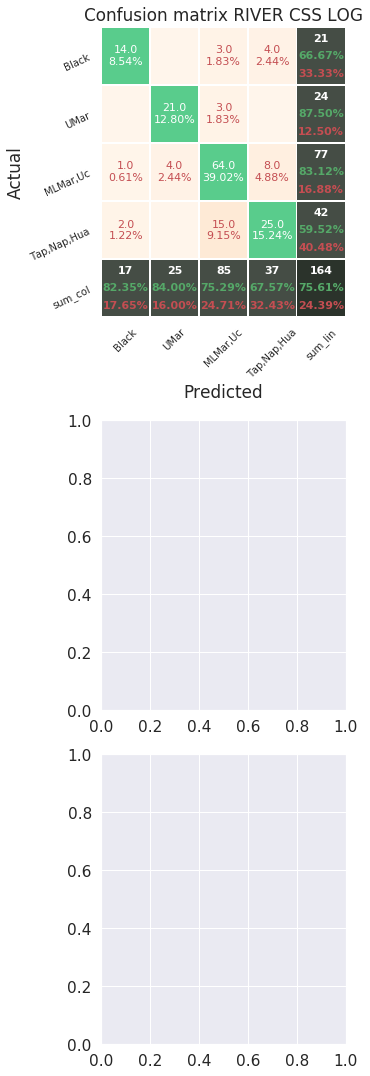

In [17]:
confusionvisualisation(riv_enet_ran_riv_sc)

In [14]:
# Dissimilarity full dataframe
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
ysetlist = [wwfdf.loc[:,"Water"]]*3
ygrouplist =  [wwfdf.loc[:,"Area_group"]]*3

scaler = prepro.StandardScaler(with_mean=True)


dis_logl2_full_sc = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist=ygrouplist,penalty = "l2")
dis_logl1_full_Sc = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist,penalty = "l1")

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 9  4]
 [ 3 16]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 5 27]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [13 13]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 22]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [10  9]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[4 1]
 [7 4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [4 8]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[13  0]
 [ 5 14]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 3 29]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 4 22]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [12  7]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 5  0]
 [11  0]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [4 8]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[12  1]
 [ 4 15]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 6 26]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [11 15]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [11  8]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[5 0]
 [8 3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [6 6]]
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 19]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 22]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 4 15]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 11]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3 10]
 [ 0 19]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 23]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 3 16]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3 10]
 [ 0 19]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [56]:
# Dissimilarity full100s dataframe
index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
ysetlist = [wwfdf.loc[full_s_ind,"Water"]]*3
ygrouplist =  [wwfdf.loc[full_s_ind,"Area_group"]]*3

scaler = prepro.StandardScaler(with_mean=True)


dis_logl2_full100s_sc = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist=ygrouplist,penalty = "l2")
dis_logl1_full100s_sc = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist,penalty = "l1")
scaler = None
dis_logl2_full100s = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist=ygrouplist,penalty = "l2")
dis_logl1_full100s = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist,penalty = "l1")

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 5 27]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[10  3]
 [ 3 15]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [13 13]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 21]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [10  9]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[4 1]
 [7 4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [4 8]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 30]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[13  0]
 [ 4 14]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 4 22]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [12  7]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 5  0]
 [11  0]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [4 8]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 3 29]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[12  1]
 [ 4 14]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [11 15]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [17  2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[5 0]
 [8 3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [6 6]]
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 18]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 20]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 4 15]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 11]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3 10]
 [ 0 18]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 21]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 3 16]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3 10]
 [ 0 18]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 18]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 6 20]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 1 18]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 10]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 18]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 1 18]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  9]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  9]
 [ 0 18]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 5 21]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 7 15]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 0 18]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 6 20]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 5  8]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 1 18]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [140]:
# Dissimilarity river dataframe
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.Water]*3
# ygrouplist =  [wwfdf.Area_group]*3

scaler = prepro.StandardScaler(with_mean=False)
scaler = None

dis_logl2_riv= mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist=ygrouplist,penalty = "l2")
dis_logl1_riv = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist= ygrouplist,penalty = "l1")
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"Water"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3


# dis_logl2_riv100s_sc= mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist=ygrouplist,penalty = "l2")
# dis_logl1_riv100s_sc = mth.runningsplittest(GroupKFold,mth.log_cv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist= ygrouplist,penalty = "l1")

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 9  4]
 [ 2 17]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 6 20]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [12  0]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 6  7]
 [ 1 18]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 6 20]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 3 16]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [4 8]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.0min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  9]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   41.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   12.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 9 15]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   44.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 3 16]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.4min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   31.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0]
 [5 7]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   43.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   16.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 3 21]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 4 15]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 25 candidates, totalling 150 fits
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [25]:
# Rivers as labels
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.river_label]*3

scaler = prepro.StandardScaler(with_mean=False)
resampler = RandomOverSampler(random_state=11235)
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# # ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

riv_logl2_riv_sc_ros_mult= mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler,resampler= resampler)
resampler = BorderlineSMOTE(random_state = 11235,kind = "borderline-2",n_jobs =-1)
riv_logl2_riv_sc_smote2_mult= mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler,resampler= resampler)

resampler = ADASYN(random_state = 11235,n_jobs =-1)

riv_logl2_riv_sc_adasyn_mult= mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler,resampler= resampler)


# loc_logl1_riv_sc_ros_mult = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l1",scaler = scaler,resampler = resampler)

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[2 0 0 1]
 [0 4 0 0]
 [0 0 4 7]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[3 0 0 0]
 [0 4 0 0]
 [0 0 9 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 5 6 0]
 [0 0 1 5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[3 0 0 0]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 2 4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  2  1  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[0 0 0 3]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 1 1]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished


[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[3 0 0 0]
 [0 4 0 0]
 [0 3 8 0]
 [1 0 0 5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[3 0 0 0]
 [0 3 0 0]
 [0 0 6 5]
 [0 0 3 3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 3 6 2]
 [0 0 2 4]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 2 1 0]
 [0 0 9 2]
 [0 0 4 2]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[ 0  0  0  3]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  5  1]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 1 0]
 [0 4 0 0]
 [0 0 3 8]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 10  1]
 [ 0  0  6  0]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 8 0]
 [2 0 1 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 4 2]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[3 0 0 0]
 [0 3 0 0]
 [1 1 9 0]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished


[[ 1  0  0  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 0 1]
 [0 4 0 0]
 [0 0 2 9]
 [0 0 1 5]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   55.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 1 3 0]
 [0 0 9 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 4 7 0]
 [0 0 0 6]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 3 0 0]
 [0 0 6 5]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 0 1]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 2 4]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 1  0  1  1]
 [ 0  2  1  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 0 2]
 [0 3 0 0]
 [0 0 9 2]
 [1 0 2 3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 0 2]
 [0 2 0 2]
 [0 0 6 5]
 [0 1 2 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 1 3 0]
 [0 0 8 3]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 8 1]
 [0 0 0 6]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  2  4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 0 1]
 [0 3 0 0]
 [0 5 6 0]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[1 0 1 1]
 [0 2 1 0]
 [0 0 8 3]
 [0 0 2 4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 0  0  0  3]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  2  3]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 1 0]
 [0 4 0 0]
 [0 0 3 8]
 [0 0 2 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 0 8 3]
 [0 0 5 1]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 8 1]
 [2 0 1 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   54.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 3 0 0]
 [1 0 8 2]
 [0 0 3 3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   55.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   56.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   54.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 1  0  0  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 0 1]
 [0 4 0 0]
 [0 0 4 7]
 [0 0 2 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 0 9 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 4 7 0]
 [0 0 1 5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 3 0 0]
 [0 0 8 3]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 0 1]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[0 0 0 3]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 2 4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 0 2]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 8 1]
 [1 0 0 5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[2 0 0 1]
 [0 3 0 0]
 [0 3 7 1]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[2 0 0 1]
 [0 3 0 0]
 [0 0 8 3]
 [0 0 2 4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  2  3]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 0 1 0]
 [0 4 0 0]
 [0 0 3 8]
 [0 0 2 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 0 9 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [2 0 2 2]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 3 3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.0min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[2 1 0 0]
 [0 3 0 0]
 [1 2 8 0]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  0  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]


In [129]:
# River Full
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
ysetlist = [wwfdf.loc[:,"river_label"]]*3

scaler = prepro.StandardScaler(with_mean=True)


riv_logl2_full_sc_meant = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler)
riv_logl1_full_sc_meant = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l1",scaler = scaler)

scaler = prepro.StandardScaler(with_mean=False)
riv_logl2_full_sc = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler)
riv_logl1_full_sc = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l1",scaler = scaler)

index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
ysetlist = [wwfdf.loc[full_s_ind,"river_label"]]*3

scaler = prepro.StandardScaler(with_mean=True)


riv_logl2_full100s_sc_meant = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler)
riv_logl1_full100s_sc_meant = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l1",scaler = scaler)

scaler = prepro.StandardScaler(with_mean=False)
riv_logl2_full100s_sc = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l2",scaler = scaler)
riv_logl1_full100s_sc = mth.runningsplittest(StratifiedKFold,mth.log_cv,index,xsetlist,ysetlist,penalty = "l1",scaler = scaler)


Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    6.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 2 2 0]
 [5 1 2 3]
 [2 1 0 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 4 7 0]
 [0 0 3 3]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 4 4 3]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [2 2 5 2]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 2 5 3]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [2 0 7 2]
 [3 0 0 3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 1 9 1]
 [1 0 0 5]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [2 0 6 3]
 [1 0 2 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 1 3 0]
 [0 2 7 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 6 2]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [2 2 4 3]
 [0 0 0 6]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 6 3]
 [1 0 1 4]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 2  0  1  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 1 9 1]
 [1 0 0 5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 1 3 0]
 [2 0 3 6]
 [0 1 1 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 1 3 0]
 [0 3 8 0]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 5 3 3]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 2 5 3]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 7 2]
 [2 0 1 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  0  6]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 1 0 0]
 [0 2 2 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 0 7 4]
 [0 0 1 5]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 4 5 2]
 [2 0 3 1]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 2 4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 2 1 0]
 [0 1 9 1]
 [0 0 5 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  1  1  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 2 7 2]
 [0 0 3 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 9 0]
 [0 0 6 0]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  3  2]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  0  2]
 [ 0  4  0  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  1  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 1 9 1]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 3 3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  0  3]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [1 0 7 3]
 [1 0 1 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 1 8 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 7 1]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 2 5 4]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 2 6 3]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  3  2]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 9 2]
 [0 0 2 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 1 8 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 1]
 [0 2 8 1]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 6 3]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  0  2]
 [ 0  4  0  0]
 [ 0  0 10  1]
 [ 0  0  2  4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 1 9 1]
 [1 0 1 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 5 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  2  0  0]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  5  1]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 1 7 3]
 [1 0 2 3]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 4 5 2]
 [2 0 3 1]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 2 4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 2 7 2]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  1  1  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  2  3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 9 2]
 [0 0 4 2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 0 8 3]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 2 7 2]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  5  1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  2  3]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  0  2]
 [ 0  4  0  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  1  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  1 10  0]
 [ 1  0  0  5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 3 3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 2 2 0]
 [5 1 2 3]
 [2 1 0 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 4 7 0]
 [0 0 3 3]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 4 4 3]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [2 2 5 2]
 [0 0 0 6]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 6 3]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [3 0 6 2]
 [3 0 0 3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 1 8 1]
 [1 0 0 5]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [3 0 6 2]
 [1 0 2 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 1 0]
 [0 2 8 1]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 3 5 3]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [2 2 4 3]
 [0 0 0 6]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 6 3]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 2  0  1  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 1 8 1]
 [1 0 0 5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 1 3 0]
 [2 0 3 6]
 [0 1 1 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 1 0]
 [0 3 8 0]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 5 3 3]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 7 3]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 7 2]
 [2 0 2 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    4.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 0  0  0  6]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 2 2 0]
 [0 4 5 2]
 [2 1 0 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 8 3]
 [0 0 1 5]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 4 5 2]
 [2 0 3 1]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 1 2 0]
 [0 2 9 0]
 [1 0 4 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 1  0  2  3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  0  2]
 [ 0  1  3  0]
 [ 0  1 10  0]
 [ 0  0  4  2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  2  1  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [2 0 3 1]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 2 4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 2 8 0]
 [0 0 6 0]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 1  0  3  2]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 1 3 0]
 [0 3 7 1]
 [0 0 3 3]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 9 1]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  3  3]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 4 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  1  2]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 0  0  4  2]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [1 4 3 3]
 [1 0 1 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 3 7 1]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 2 6 3]
 [0 0 0 6]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 1 7 3]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  3  2]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 0 9 1]
 [0 0 1 5]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [0 0 9 2]
 [0 0 2 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 9 1]
 [0 0 4 2]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 0 1]
 [0 1 9 1]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 7 2]
 [0 0 5 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 0 9 1]
 [0 0 1 5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  0  2]
 [ 0  4  0  0]
 [ 0  0 10  1]
 [ 0  0  2  4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 9 1]
 [2 0 0 4]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 5 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 0  0  3  3]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 1 0]
 [0 3 6 2]
 [1 0 1 4]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 2 4]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 4 5 2]
 [2 0 3 1]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 9 1]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 2 9 0]
 [1 0 4 1]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 1  0  2  3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 0 9 2]
 [1 0 3 2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  2  1  0]
 [ 0  0 10  1]
 [ 0  0  3  3]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 2 7 2]
 [1 0 2 3]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 0 9 2]
 [0 0 1 5]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 2 8 0]
 [0 0 3 3]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  1  4]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  2  1  0]
 [ 0  0 10  0]
 [ 1  0  3  2]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  1  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
1
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
2
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  1 10  0]
 [ 1  0  0  5]]
3
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 9 1]
 [0 0 2 4]]
4
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 0 9 1]
 [1 0 3 2]]
5
Fitting 6 folds for each of 25 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  0  5]]
6
Fitting 6 folds for each of 25 candidates, totalling 150 fits
[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 0  0  3  3]]


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [226]:
dis_logl1_cv2strat.to_pickle("dis_logl1_cv2strat")
dis_logl2_cv2strat.to_pickle("dis_logl2_cv2strat")
dis_logl1_rscent.to_pickle("dis_logl1_rscent")
dis_logl2_rscent.to_pickle("dis_logl2_rscent")
dis_logl1_standscale.to_pickle("dis_logl1_standscale")
dis_logl2_standscale.to_pickle("dis_logl2_standscale")
dis_logl1_standscalemeanf.to_pickle("dis_logl1_standscale")
dis_logl2_standscalemeanf.to_pickle("dis_logl2_standscale")


# GP

In [416]:
gpc = GaussianProcessClassifier(max_iter_predict=1000,n_restarts_optimizer=5,n_jobs=-1,kernel=kernels.Sum(kernels.DotProduct(),kernels.RBF()))
gpc.fit(X_train,y_train)
gpc.score(X_test,y_test)

/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([216.24194661,   1.09718323]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 4, 'warnflag': 2}
  ConvergenceWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.35357421e-01, -3.96865879e-09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpc.py:434: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 6.37653611e-01, -8.51951275e-09]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/home/adamingas/anaconda3/lib/python3.7/

0.9393939393939394

# Hypothesis testing of different splits
The aim is to test how well logistic regression and other classifiers perform under different train test splits 


In [ ]:
def splithypothesis(*args,cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        CVfolds = cvgenerator(n_splits = number_of_folds)
        Kfolds = CVfolds.split(xtrain,y = set_for_kfold,groups=set_for_kfold)
#         for ind1,ind2 in Kfolds:
#             print(set_for_kfold.iloc[ind2])
        # Perform grid CV using Kfolds as folds.
        parameters,CVgrid,coef =model_cv(args[0],X=xtrain,y = ytrain,trainfolds=Kfolds)
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, CVgrid.predict(xtest))
        
        best_parameters.append(parameters)
        scoring_results.append( metrics.accuracy_score(ytest, CVgrid.predict(xtest)))
        coefficients.append(coef)
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
def splithypothesiscoin(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Water,groups=yset.Water)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        p =ytrain.mean()
        conf_matrix =np.array([[(1-p)*(ytest==0).sum(),(p)*(ytest==0).sum()],[(1-p)*(ytest==1).sum(),(p)*(ytest==1).sum()]])
        
        scoring_results.append( (conf_matrix[0,0]+conf_matrix[1,1])/(conf_matrix.sum()))
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
def runningsplittest(foldgenerator,model_cv,index,xsetlist,ysetlist,**kwargs):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =splithypothesis(kwargs,cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [ ]:
index = ["Normal","min"]
ysetlist = [wwfdf,wwfdfmin]
xsetlist = [pcoaCss,otudfMinCss]
#dis_coin=runningsplittest(GroupKFold,None,index,xsetlist,ysetlist)
#sim_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)
rand_coin=runningsplittest(StratifiedKFold,None,index,xsetlist,ysetlist)

## Running the Hypothesis

In [ ]:
dissimilarityscore_otu_lr =[0.65625,
 1.0,
 0.9285714285714286,
 0.5833333333333334,
 0.9,
 0.75,
 0.8333333333333334]
hypothesisresults.write(str(similarityscore_otu_lr))

In [ ]:
similarityscore_otu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otu_lr))

In [ ]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
similarityscore_otuCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(similarityscore_otuCss_lr))

In [ ]:
similarityscore_pcoaCss_lr,best_par_pcoaCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

In [ ]:
similarityscore_pcoaOtu_lr,best_par_pcoaOtu_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("similarityscore_pcoaCss_lr")
hypothesisresults.write(str(similarityscore_pcoaCss_lr))

In [ ]:
similarityscore_otuMinCss_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("similarityscore_otuMinCss_lr")
hypothesisresults.write(str(similarityscore_otuMinCss_lr))

In [ ]:
similarityscore_nmds_lr = splithypothesis(cvgenerator=StratifiedKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
dissimilarityscore_nmds_lr = splithypothesis(cvgenerator=GroupKFold,xset=nmds20,number_of_splits=7,number_of_folds=6)

In [ ]:
dissimilarityscore_otuCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6,yset=wwfdfmin)
hypothesisresults.write("dissimilarityscore_otuCss_lr")
hypothesisresults.write(str(dissimilarityscore_otuCss_lr))

In [ ]:
dissimilarityscore_pcoaCss_lr,best_par_diss_pcoaCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaCss.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

In [ ]:
dissimilarityscore_pcoaOtu_lr,best_par_diss_pcoaOtu_lr = splithypothesis(cvgenerator=GroupKFold,xset=pcoaOtu.iloc[:,0:58],model_cv=log_cv,number_of_splits=7,number_of_folds=6)
hypothesisresults.write("dissimilarityscore_pcoaCss_lr")
hypothesisresults.write(str(dissimilarityscore_pcoaCss_lr))

In [ ]:
dissimilarityscore_otuMinCss_lr = splithypothesis(cvgenerator=GroupKFold,xset=otudfMinCss,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otuMinCss_lr))

In [ ]:
dissimilarityscore_otu_lr =splithypothesis(cvgenerator=GroupKFold,xset=otudf,number_of_splits=7,number_of_folds=6)
hypothesisresults.write(str(dissimilarityscore_otu_lr))

In [ ]:
# print("NMDS")
# print(np.array( similarityscore_nmds_lr).mean())
# print(np.array( similarityscore_nmds_lr).var())
print("OTU")
print(np.array( similarityscore_otu_lr).mean())
print(np.array( similarityscore_otu_lr).var())
print("OTU Css")
print(np.array( similarityscore_otuCss_lr).mean())
print(np.array( similarityscore_otuCss_lr).var())
print("OTU Min Css")
print(np.array( similarityscore_otuMinCss_lr).mean())
print(np.array( similarityscore_otuMinCss_lr).var())
print("PCoA Otu")
print(np.array( similarityscore_pcoaOtu_lr).mean())
print(np.array( similarityscore_pcoaOtu_lr).var())

print("PCoA Css")
print(np.array( similarityscore_pcoaCss_lr).mean())
print(np.array( similarityscore_pcoaCss_lr).var())

print("Diss OTU")
print(np.array( dissimilarityscore_otu_lr).mean())
print(np.array( dissimilarityscore_otu_lr).var())

print("Diss OTU Css")
print(np.array( dissimilarityscore_otuCss_lr).mean())
print(np.array( dissimilarityscore_otuCss_lr).var())
print("Diss OTU Min Css")
print(np.array( dissimilarityscore_otuMinCss_lr).mean())
print(np.array( dissimilarityscore_otuMinCss_lr).var())

print("Diss PCoA Otu")
print(np.array( dissimilarityscore_pcoaOtu_lr).mean())
print(np.array( dissimilarityscore_pcoaOtu_lr).var())


print("Diss PCoA Css")
print(np.array( dissimilarityscore_pcoaCss_lr).mean())
print(np.array( dissimilarityscore_pcoaCss_lr).var())


# Bayesian logistic regression using pymc3

I cant get it to work with either nmds or otutable, there might be something wrong with the code or with the implementation.

In [ ]:
class BaysianClassifier:
    def __init__(self,niterations,regularisation,sampler=pm.NUTS):
        self.niter = niterations
        self.reg = regularisation
        self.sampler = sampler
    
    def fit(self,X,y,intercept=True,sigma=1):
        self.bay = pm.Model()
        self.x_shared = shared(np.array(X))
        with self.bay:
            # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
            mu = 0#pm.Normal('mu', 0.0, sd=1)
            inter = tt.constant(0)
            lam = sigma#pm.HalfCauchy('sd', 1.0)
            if self.reg == "l1":
                beta = pm.Laplace("betas",mu,lam,shape = X.shape[1])
                if intercept == True:
                    inter =  pm.Laplace("intercept",mu,lam,shape = 1)
            if self.reg == "l2":
                beta = pm.Normal("betas",mu,lam,shape = np.array(X).shape[1])
                if intercept == True:
                    inter =  pm.Normal("intercept",mu,lam,shape = 1)
                
                
            y_hat = tt.dot(self.x_shared,beta)+ inter
            # Calculating the probability of water being white p(y=1|mu) so that we can get 
            # p(y|x,beta) ~ Binomial(y|mu)
            #mu =logit(y_hat)
            y_obs = pm.Bernoulli("Y_obs",logit_p=y_hat,observed = y)
            self.MAP = pm.find_MAP()
            self.trace = pm.sample(self.niter,random_seed=11235,step =self.sampler() )
            #start= {"beta":freq.coef_.T}bl
            
    def predict(self,X,samples=2000):
        self.x_shared.set_value(X)
        ppc = pm.sample_posterior_predictive(self.trace,model = self.bay,samples=samples)
        yone =(ppc["Y_obs"] ==1).sum(axis=0)
        yzero =(ppc["Y_obs"] ==0).sum(axis=0)
        prediction_prob =st.beta(yone,yzero).mean()
        prediction_prob[np.isnan(prediction_prob)] =1
        return(prediction_prob)

In [ ]:
def bayesiantest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        best_parameters.append(copy.deepcopy(model_cv.trace))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction>0.5)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
def mletest(cvgenerator,xset,model_cv,number_of_splits,number_of_folds,yset=wwfdf):
    """
    Tests the splits hypothesis on the LogisticRegression classifier.
    
    Input:
    cvgenerator: A cross-validator that can split data into folds
    xset: The features that will be used on the classifier
    model_cv: A function that will perform the cross-validation and select the hyperparameters
              of the classifier based on its performance on the cvgenerators folds
              examples are log_cv and rfr_cv
    number_of_splits: Number of ways to split the data into train-test
    number_of_folds: Number of ways to split the train set into validation sets
    yset: Labels of data, must match length of xset
    Output:
    scoring_results: A list of the accuracy of the classifier on each test fold
    best_parameters: A list of parameters used by the classifier to calculate the score for each test fold
    coefficients: A list of arrays with the iportance of the features
    """
    np.random.seed(11235)
    traintestsplit  = cvgenerator(n_splits=number_of_splits)
    Ksets = traintestsplit.split(xset,y =yset.Area_group,groups=yset.Area_group)
    # scoring_results is a list with the scores of the estimator on each test set in
    # the traintestsplit folds.
    best_parameters =[]
    scoring_results = []
    coefficients =[]
    confusion = np.zeros((2,2))
    for i,index in enumerate( Ksets):
        train_index,test_index = index
        xtrain,xtest = xset.iloc[train_index],xset.iloc[test_index]
        ytrain,ytest = yset.Water.iloc[train_index],yset.Water.iloc[test_index]
        #set_for_kfold = yset.Area_group.loc[xtrain.index]
        print(i)
        np.random.seed(11235)
        model_cv =LogisticRegression(fit_intercept=True,penalty="l1",C=1)
        # Perform grid CV using Kfolds as folds.
        model_cv.fit(xtrain,ytrain)
        coefficients.append(np.append(model_cv.coef_,model_cv.intercept_))
        modelrpediction = model_cv.predict(xtest)
        
        # parameters are the best parameters of the model and CVgrid is the output
        # of the GridSearchCV method
        print(ytest.shape)
        
        conf_matrix = metrics.confusion_matrix(ytest, (modelrpediction)*1)
        
        
        scoring_results.append( metrics.accuracy_score(ytest, (modelrpediction>0.5)*1))
        
        if conf_matrix.shape == (1,1):
            conf_matrix = np.array([[0,0],[0,conf_matrix.item()]])
        print(conf_matrix)
        confusion += conf_matrix
        
    return(scoring_results,best_parameters,coefficients,confusion)

In [ ]:
logistcmodel = LogisticRegression(fit_intercept=True,penalty="l1",C=1)
nmds_logl1 = runningbayesian(StratifiedKFold,logistcmodel,index,xsetlist,ysetlist)

In [ ]:
nmdscoefficients= nmds_logl1.Coefficients[0][0]

In [ ]:
def runningbayesian(foldgenerator,model_cv,index,xsetlist,ysetlist):
    """
    Input
    foldgenerator: Stratified or Group KFold
    model_cv: The model CV to use, log_cv or rfr_cv
    
    """
    dictr ={"Scores":[],"Parameters":[],"Coefficients":[],"Confusion":[]}
    if index ==None:
        index = ["OTU","OTU CSS","OTU MIN CSS","PCoA","PCoA CSS"]
        xsetlist = [otudf,otudfCss,otudfMinCss,pcoaOtu,pcoaCss]
        ysetlist =[wwfdf,wwfdf,wwfdfmin,wwfdf,wwfdf]
    for i,j in enumerate(index):
        print(i)
        # Running the hypothesis for all cases in the index
        scoring,best_parameters,coefficents,confusion =bayesiantest(cvgenerator=foldgenerator,xset=xsetlist[i],model_cv=model_cv,
                                number_of_splits=7,number_of_folds=6,yset=ysetlist[i])

        dictr["Scores"]+=[scoring]
        dictr["Parameters"] += [best_parameters]
        dictr["Coefficients"] += [coefficents]
        dictr["Confusion"] += [confusion]
    dataf =pd.DataFrame(data = dictr,index=index)
    return(dataf)

In [ ]:
bclsfr = BaysianClassifier(8000,"l1")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl1_8k = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

In [ ]:
sim_baysl2.to_pickle("sim_baysl2")
dissim_baysl2.to_pickle("dissim_baysl2")

In [ ]:
bclsfr = BaysianClassifier(4000,"l2")

# index = ["OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf]
index =["nmds"] #["PCoA 99%"]#,"PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
xsetlist =[nmds20]# [pcoaOtu.iloc[:,0:55]]#,pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
ysetlist =[wwfdf]#,wwfdf,wwfdf,wwfdf]
dissim_baysl2 = runningbayesian(GroupKFold,bclsfr,index,xsetlist,ysetlist)

In [ ]:
sim_baysl1 = pd.read_pickle("sim_baysl1")
dissim_baysl1_v2 = pd.read_pickle("dissim_baysl1")

In [ ]:
%matplotlib inline
plt.style.use('seaborn-darkgrid')

#pm.plot_posterior(sim_baysl1.Parameters["nmds"][0])
pm.forestplot(sim_baysl1_8k.Parameters["nmds"][0])
plt.scatter(nmdscoefficients,np.linspace(0.5,59,21),c="red")
plt.vlines(x=0,ymin=-1,ymax=300,linestyles="dashed",colors="blue")
plt.savefig("forest_sim_l1.png",dpi=300)

In [ ]:
%matplotlib inline 
pm.fores


In [ ]:
bclsfr.predict(Xn_test)

In [ ]:
%matplotlib inline 

pm.traceplot(deepcopytrace);


In [ ]:
baybetas =pm.find_MAP(model=bay)["beta"]


In [ ]:
df_trace = pm.trace_to_dataframe(trace[niter//2:])
betas =df_trace.mean(0)[1:21]
#intercept = df_trace.mean(0)[-1]
#pm.find_MAP(model=bay)
#bay.Y_obs

In [ ]:
def predict(X,betas,intercept):
    
    v = np.dot(X,betas) + intercept
    return(np.exp(v)/(1+np.exp(v)))

In [ ]:
(predict(Xn_test,betas=betas,intercept=0) >= 0.5 )*1 ==y_test.bool

In [ ]:
nobservations =150
covariates = np.random.randn(nobservations, 20)
covariates = np.hstack((np.ones((nobservations, 1)), covariates))

true_coefficients = 5 * np.random.rand(21)
true_logits = np.dot(covariates, true_coefficients) 
true_probs = 1.0 / (1.0 + np.exp(-true_logits))
observed_labels = (np.random.rand(nobservations) < true_probs).astype(np.int32)

In [ ]:
covariates=Xn_train
covariates = np.hstack((np.ones((Xn_train.shape[0], 1)), covariates))
testset = np.hstack((np.ones((Xn_test.shape[0], 1)), Xn_test))
observed_labels = y_train.bool#(wwfdf.Water =="White")*1

In [ ]:
testlog = LogisticRegression(penalty="l2",multi_class="ovr",solver= "saga",max_iter=100000,fit_intercept=False)
testlog.fit(covariates,observed_labels)
#plt.scatter(true_coefficients, testlog.coef_[0, :])
print(testlog.coef_)
#plt.show()
testlog.score(testset,y_test.bool)

In [ ]:
nn = 20000
with pm.Model() as testmodel:
    # Weights of the features have a laplace prior which is the same as l1 when minimising the loss function
    beta = pm.Normal('beta', 0.0, sd=3.0, shape=20)
    intercept = pm.Normal("inter",0,sd=3,shape=1)
    likelihood = pm.Bernoulli('likelihood', logit_p= tt.dot(Xn_train,beta)+intercept , observed=observed_labels)
    tracetest =pm.sample(nn,step=pm.NUTS(),random_seed=11235)

In [ ]:
%matplotlib inline
pm.traceplot(tracetest)

In [ ]:
maptest = (pm.find_MAP(model=testmodel))
maptest_beta = maptest["beta"]
maptest_inter = maptest["inter"]
#print(true_coefficients)
#plt.scatter(true_coefficients,maptest)

In [ ]:
# pred_probs =predict(testset,baybetas,0) >=0.5
# print((y_test.bool == pred_probs).mean())
pred_probs =predict(Xn_test,maptest_beta,maptest_inter) >=0.5
(y_test.bool == pred_probs).mean()

# SVM

In [150]:
def svm_cv(*args,X, y,trainfolds,**kwargs):
    """
    Function performs Grid search Cross validation with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    try:
        kernel = args[0]["kernel"]
    except KeyError:
        kernel = "poly"
        print("You haven't specified a kernel, we will be using poly")
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    if kernel == "poly":
        param_grid ={"kernel":["poly"],"gamma":["auto","scale",0.1,1,10],"class_weight":["balanced",None],
                    'C':[0.1, 1, 0.5], "degree":[1,2],"coef0" :[0,0.1,1,0.001]}
    elif kernel=="custom":
        param_grid ={"kernel":[braysvm],"gamma":["auto","scale",0.1,1,10],"class_weight":["balanced",None],
                    'C':[0.1, 1, 0.5]}
    else:
        param_grid ={"kernel":["rbf"],"gamma":["auto","scale",0.1,1,10],"class_weight":["balanced",None],
                    'C':[0.1, 1, 10, 100, 1000]}
    gsc = GridSearchCV(
        estimator=SVC(random_state=11235,decision_function_shape="ovr"),
        param_grid=param_grid,
        cv=trainfolds, scoring = ["accuracy"], verbose=-1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_

    return best_params,grid_result,None

In [209]:
# Dissimilarity
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.Water]*3
ygrouplist =  [wwfdf.Area_group]*3
# ygrouplist = [wwfdf.Site]*3
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"Water"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

scaler = prepro.StandardScaler(with_mean=True)

#scaler = None
#scaler = prepro.RobustScaler(quantile_range=(0.25,0.75),with_centering=True)
#scaler = prepro.PolynomialFeatures(degree=2)



dis_svm_riv_sc_meant = mth.runningsplittest(GroupKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly",
                                          number_of_splits=7,number_of_folds = 6,ygrouplist=ygrouplist)


Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    3.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 5  8]
 [ 0 19]]
1


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 30]]
2


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 22]]
4


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 8  5]
 [ 0 19]]
1


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2


[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3


[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4


[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 1 18]]
5


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 5  8]
 [ 0 19]]
1


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2


[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  1]
 [ 0 26]]
3


[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  1]
 [ 0 11]]
6


[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    1.4s


[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [156]:
# River label
# index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
# xsetlist = [riverdf,riverdfCss,riverdfCssLog]
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]

ysetlist = [wwfdf.river_label]*3
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

scaler = prepro.StandardScaler(with_mean=False)
resampler= SVMSMOTE(random_state=11235,svm_estimator=SVC(kernel="poly",degree=1))
#scaler = prepro.RobustScaler(quantile_range=(0.25,0.75),with_centering=True)
#scaler = prepro.PolynomialFeatures(degree=2)

riv_svm_full_sc = mth.runningsplittest(StratifiedKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly",
                                          number_of_splits=7,number_of_folds = 6)


Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1216 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 4 0 0]
 [0 4 2 5]
 [1 0 1 4]]
1
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 1 8 2]
 [0 0 2 4]]
2
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 6 2]
 [1 0 2 3]]
3
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 7 3]
 [0 0 0 6]]
4
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 1 0 1]
 [0 3 0 0]
 [0 2 7 2]
 [1 0 4 1]]
5
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  1  4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 8 3]
 [0 0 3 3]]
1
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 1 0]
 [0 1 9 1]
 [0 0 4 2]]
2
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 1]
 [0 2 8 1]
 [2 0 1 3]]
3
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 7 2]
 [0 0 5 1]]
5
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 2 4]]
1
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
2
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  1 10  0]
 [ 2  0  0  4]]
3
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 8 2]
 [0 0 1 5]]
4
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 9 0]
 [0 0 5 1]]
5
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [151]:
# Dissimilarity full dataframe
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
# ysetlist = [wwfdf.loc[:,"Water"]]*3
# ygrouplist =  [wwfdf.loc[:,"Area_group"]]*3
ysetlist = [wwfdf.loc[:,"river_label"]]*3

scaler = prepro.StandardScaler(with_mean=False)


riv_svm_full_sc = mth.runningsplittest(StratifiedKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly")

scaler = prepro.StandardScaler(with_mean=True)
riv_svm_full_sc_meant = mth.runningsplittest(StratifiedKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly")

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   14.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 4 0 0]
 [0 4 2 5]
 [1 0 1 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 1 8 2]
 [0 0 2 4]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 6 2]
 [1 0 2 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 7 3]
 [0 0 0 6]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 1 0 1]
 [0 3 0 0]
 [0 2 7 2]
 [1 0 4 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  1  4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 8 3]
 [0 0 3 3]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 1 0]
 [0 1 9 1]
 [0 0 4 2]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 1]
 [0 2 8 1]
 [2 0 1 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 7 2]
 [0 0 5 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 2 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  1 10  0]
 [ 2  0  0  4]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 8 2]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 9 0]
 [0 0 5 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 4 0 0]
 [0 4 2 5]
 [1 0 1 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 2 0]
 [0 1 8 2]
 [0 0 2 4]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 3 6 2]
 [1 0 2 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 7 3]
 [0 0 0 6]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 1 0 1]
 [0 3 0 0]
 [0 2 7 2]
 [1 0 4 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 1  0  1  4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 8 3]
 [0 0 3 3]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 1 0]
 [0 1 9 1]
 [0 0 4 2]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 1]
 [0 2 8 1]
 [2 0 1 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 7 2]
 [0 0 5 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  2  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  1  5]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 2 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  1 10  0]
 [ 2  0  0  4]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 8 2]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 1 9 0]
 [0 0 5 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.6s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [154]:
# Dissimilarity full100s dataframe
index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
#ysetlist = [wwfdf.loc[full_s_ind,"Water"]]*3
#ygrouplist =  [wwfdf.loc[full_s_ind,"Area_group"]]*3
ysetlist = [wwfdf.loc[full_s_ind,"river_label"]]*3

scaler = prepro.StandardScaler(with_mean=False)
riv_svm_full100s_sc = mth.runningsplittest(StratifiedKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly")
# scaler =None

# riv_svm_full100s = mth.runningsplittest(GroupKFold,svm_cv,index,xsetlist,ysetlist,scaler = scaler,kernel ="poly",
#                                        ygrouplist=ygrouplist)


Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 2 2 0]
 [0 4 2 5]
 [1 0 1 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 8 2]
 [0 0 2 4]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 3 6 2]
 [1 0 2 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 7 3]
 [0 0 0 6]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [0 1 8 2]
 [1 0 4 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 0 9 1]
 [1 0 1 4]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [0 4 5 2]
 [0 0 3 3]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 2 1 0]
 [0 1 9 1]
 [0 0 4 2]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 1 0]
 [0 2 0 1]
 [0 1 9 1]
 [2 0 1 3]]
3


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [0 1 6 4]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 3 0 0]
 [1 1 8 1]
 [0 0 5 1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 2 0]
 [0 3 0 0]
 [0 0 9 1]
 [0 0 2 4]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 1 0]
 [0 0 7 4]
 [0 0 2 4]]
1


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
2


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  1 10  0]
 [ 2  0  0  4]]
3


[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 502 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1222 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   13.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [1 0 8 2]
 [0 0 1 5]]
4


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  5  1]]
5


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1040 tasks      | elapsed:    9.3s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 10  0]
 [ 0  0  2  4]]


[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:   12.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# AdaBoost

In [243]:
def ada_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    trainfolds1 = list(trainfolds)
    cv_svm = GridSearchCV(
        estimator=SVC(random_state=11235),
        param_grid={"kernel":["poly"],"gamma":["auto","scale",0.1,1,10],"class_weight":["balanced",None],
                    'C':[0.1, 1, 0.5], "degree":[1,2],"coef0" :[0,0.1,1,0.001]},
        cv=trainfolds1, scoring = ["accuracy"], verbose=-1, n_jobs=-1,refit = "accuracy",
        return_train_score = False
)
    svm_params =cv_svm.fit(X,y).best_params_
    print(svm_params)
    print(trainfolds)
    gsc = GridSearchCV(
        estimator=AdaBoostClassifier(random_state=11235,base_estimator = SVC(probability = True,**svm_params)),
        param_grid={
            'learning_rate': [0.5,1,2],
            'n_estimators': [50]
        },
        cv=trainfolds1, scoring = ["accuracy","f1"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
#     gsc = AdaBoostClassifier(random_state=11235,learning_rate=1,n_estimators=2000)
    grid_result = gsc.fit(X, y)
#     coefficients = gsc.feature_importances_
#     best_params = gsc.estimator_errors_
    best_params = grid_result.best_params_
    #coefficients =grid_result.best_estimator_.feature_importances_
    coefficients =[]

    return (best_params,grid_result,coefficients)

In [232]:
SVC(probability=True,**{"C":2})

SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [244]:
# disSimilarity using riverdf
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.Water]*3
ygrouplist =  [wwfdf.Area_group,wwfdf.Area_group,wwfdf.Area_group]

# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"Water"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

dis_ada_riv = mth.runningsplittest(GroupKFold,ada_cv,index,xsetlist,ysetlist,ygrouplist = ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a252408>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ef48>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 1, 'class_weight': 'balanced', 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ee58>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a6bc048>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    8.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a2522a0>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    8.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  1]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ef48>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648b88>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0]
 [ 1 11]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a252228>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 2, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ef48>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 1, 'class_weight': 'balanced', 'coef0': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648b88>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    7.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63eb10>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    8.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 976 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ec78>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  1]
 [ 1 18]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 1056 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.1, 'class_weight': None, 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648048>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    9.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.4s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ef48>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    6.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    1.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.3s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648048>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1 12]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.2s remaining:    0.9s


{'C': 0.5, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648b88>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.2s remaining:    0.8s


{'C': 0.5, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ee58>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.7s


{'C': 0.5, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ecf0>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


{'C': 0.5, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648048>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.2s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    3.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.2s remaining:    0.8s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a648b88>
Fitting 6 folds for each of 3 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:    2.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:    0.1s remaining:    0.7s


{'C': 0.1, 'class_weight': 'balanced', 'coef0': 0, 'degree': 1, 'gamma': 0.1, 'kernel': 'poly'}
<generator object _BaseKFold.split at 0x7f945a63ec78>
Fitting 6 folds for each of 3 candidates, totalling 18 fits
[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    2.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# Random Forrest

In [123]:
def rfr_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestClassifier(bootstrap=False),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (500, 1000,100,300),
        },
        cv=trainfolds, scoring = ["accuracy","f1"], verbose=1, 
        n_jobs=2,refit = "f1",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [133]:
def objective_rfr(hyperparameters,X,y,trainfolds):
    """Objective function for logistic regression"""
    model = Pipeline([("resampler",BorderlineSMOTE(random_state=11235)),("RFR",RandomForestClassifier())])
    model.set_params(**hyperparameters)
#     logmodel = KNeighborsClassifier(metric = knnmetric).set_params(**hyperparameters)
    
    score = cross_val_score(model,X,y,cv=trainfolds,scoring="accuracy",n_jobs = -1)
    best_score = score.mean()
    loss = 1-best_score
    return {"loss":loss,"params":hyperparameters,"status":STATUS_OK}

In [135]:
def rfr_bcv(*args,X,y,trainfolds,**kwargs):
    """
    Bayesian optiisation of LogisticRegression
    """
    
    trainfoldlist = list(trainfolds)
    bayes_trials = Trials()
    MAX_EVALS = 300
    # Define the search space
    space = {
         'RFR__max_depth':hp.choice('RFR__max_depth',list(range(3,7))+[None]),
            'RFR__n_estimators': hp.choice("RFR__n_estimators",[100,300,500,1000]),
            "RFR__min_samples_split":hp.choice("RFR__min_samples_split",[2,3,4]),
            "RFR__class_weight" :hp.choice("RFR__class_weight", ["balanced"]),
            "RFR__bootstrap": hp.choice("RFR__bootstrap",[False]),
    "resampler__k_neighbors" : hp.choice("resampler__k_neighbors",list(np.arange(1,9))),
    "resampler__m_neighbors" : hp.choice("resampler__m_neighbors",list(np.arange(8,13))),

    "resampler__kind" : hp.choice("resampler__kind",["borderline-1","borderline-2"])
    }

    # Optimize
    best = fmin(fn =lambda x: objective_rfr(x,X=X,y=y,trainfolds=trainfoldlist), space = space, algo = tpe.suggest, 
                max_evals = MAX_EVALS, trials = bayes_trials,return_argmin=False)
    print(best)
    model =Pipeline([("resampler",BorderlineSMOTE(random_state=11235)),("RFR",RandomForestClassifier())]).set_params(**best)
    fitted_model=model.fit(X,y)
    
    return(best,fitted_model,[])

In [24]:
# Dissimilarity full dataframe
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
ysetlist = [wwfdf.loc[:,"Water"]]*3
ygrouplist =  [wwfdf.loc[:,"Area_group"]]*3




dis_rfr_full_1000trees = mth.runningsplittest(GroupKFold,mth.rfr_cv,index,xsetlist,ysetlist,ygrouplist = ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0 13]
 [ 1 18]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0]
 [ 2 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0 13]
 [ 1 18]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0 13]
 [ 1 18]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 15 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   15.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0]
 [ 0 12]]


/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [59]:
# Dissimilarity full100s dataframe
index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
ysetlist = [wwfdf.loc[full_s_ind,"Water"]]*3
ygrouplist =  [wwfdf.loc[full_s_ind,"Area_group"]]*3

dis_rfr_full100s = mth.runningsplittest(GroupKFold,mth.rfr_cv,index,xsetlist,ysetlist,ygrouplist = ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   31.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   31.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   31.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   33.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0 13]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  3]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 209 tasks      | elapsed:   18.5s


[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   33.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [223]:
riv_rfr_river.to_pickle("riv_rfr_river")


In [111]:
# disSimilarity using riverdf
# index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
# xsetlist = [riverdf,riverdfCss,riverdfCssLog]
# ysetlist = [wwfdf.Water]*3
# ygrouplist =  [wwfdf.Area_group,wwfdf.Area_group,wwfdf.Area_group]

index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
ysetlist = [wwfdf.loc[river_s_ind,"Water"]]*3
ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

dis_rfr_riv100s = mth.runningsplittest(GroupKFold,mth.rfr_cv,index,xsetlist,ysetlist,ygrouplist = ygrouplist)

0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.2s finished


[[ 1 12]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.8s finished


[[ 1  0]
 [ 0 19]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.1s finished


[[ 0  0]
 [ 1 16]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.7s finished


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.8s finished


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.3s finished


[[ 1 12]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.7s finished


[[ 0  0]
 [ 0 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.9s finished


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   25.3s finished


[[ 1 12]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 0 19]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.7s finished


[[ 0  0]
 [ 0 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.2s finished


[[ 3  2]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 60 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.7s


[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   26.5s finished


In [136]:
# Location as labels
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
#index = ["RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.river_label]*3


# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

# riv_rfr_riv100s = mth.runningsplittest(StratifiedKFold,mth.rfr_cv,index,xsetlist,ysetlist)
# ysetlist = [wwfdf.loc[:,"river_label"]]*3
# index = ["FULL","FULL CSS","FULL CSS LOG"]
# xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
# riv_rfr_full = mth.runningsplittest(StratifiedKFold,mth.rfr_cv,index,xsetlist,ysetlist)

# ysetlist = [wwfdf.loc[full_s_ind,"river_label"]]*3
# index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
# xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
#resampler = BorderlineSMOTE(n_jobs = -1,random_state=11235,kind = "borderline-1")
# resampler = RandomOverSampler(random_state=11236)
riv_rfr_riv_smote_bay = mth.runningsplittest(StratifiedKFold,rfr_bcv,index,xsetlist,ysetlist,resampler = resampler)

# resampler = SMOTE(random_state = 11235,n_jobs =-1)
# riv_rfr_riv_smote = mth.runningsplittest(StratifiedKFold,mth.rfr_cv,index,xsetlist,ysetlist,resampler = resampler)

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [02:38<00:00,  1.80it/s, best loss: 0.04193093727977448]
{'RFR__bootstrap': False, 'RFR__class_weight': 'balanced', 'RFR__max_depth': None, 'RFR__min_samples_split': 2, 'RFR__n_estimators': 100, 'resampler__k_neighbors': 4, 'resampler__kind': 'borderline-2', 'resampler__m_neighbors': 8}
[[2 0 1 0]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 2 4]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [02:58<00:00,  2.09it/s, best loss: 0.05475040257648944]
{'RFR__bootstrap': False, 'RFR__class_weight': 'balan

The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [03:49<00:00,  1.37it/s, best loss: 0.05565070999853605]
{'RFR__bootstrap': False, 'RFR__class_weight': 'balanced', 'RFR__max_depth': None, 'RFR__min_samples_split': 2, 'RFR__n_estimators': 500, 'resampler__k_neighbors': 4, 'resampler__kind': 'borderline-2', 'resampler__m_neighbors': 8}
[[3 0 0 0]
 [0 3 0 0]
 [0 1 9 1]
 [0 0 4 2]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [02:51<00:00,  3.89it/s, best loss: 0.06060606060606055]
{'RFR__bootstrap': False, 'RFR__class_weight': 'balanced', 'RFR__max_depth': None, 'RFR__min_samples_split': 3, 'RFR__n_estimators': 500, 'resampler__k_neighbors': 7, 'resampler__kind': 'borderline-1', 'resampler__m_neighbors': 8}
[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
5
The identity scaler is used. To change it pass a preprocessing class  with

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
dis_rfr_fish = runningsplittest(GroupKFold,rfr_cv,index,xsetlist,ysetlist)

In [ ]:
# concatenating
dissim_rfr_df = pd.concat([diffsimilarity_rfr_df,dissim_rfr_df_csslog_low])
sim_rfr_df = pd.concat([similarity_rfr_df,sim_rfr_df_csslog_low])

In [ ]:
sim_rfr_df.to_csv(path_or_buf="sim_rfr_df_bootfalse")
dissim_rfr_df.to_csv(path_or_buf="dissim_rfr_df_bootfalse")
sim_log_df.to_csv(path_or_buf="sim_log_df")
dissim_log_df.to_csv(path_or_buf="disssim_log_df")


## Previous attempts of rfr

In [ ]:
print("similarity RandomForestClassifier")
for j,i in enumerate( similarity_rfr_df["Scores"]):
#    print(i)
    print(diffsimilarity_rfr_df.index[j])
    print(np.array(i).mean())
    print(np.array(i).var())

In [ ]:
%matplotlib inline
sns.set()
gridpd =pd.DataFrame(grid.cv_results_)
#gridpd.columns
sns.pointplot(x="param_max_depth",y= "mean_test_roc_auc", palette=["red","blue","orange","brown"],hue="param_n_estimators",
             data=gridpd,dodge = True,ci ="sd")
#plt.ylim(0.987,1.001)
#plt.errorbar(data=gridpd,x = "param_max_depth",y= "mean_test_roc_auc",yerr="std_test_roc_auc")
g = sns.FacetGrid(gridpd, palette=["red","blue","orange"],hue="param_n_estimators"
, size=5)
g.map(plt.errorbar, "param_max_depth","mean_test_roc_auc", "std_test_roc_auc", marker="o")

In [ ]:
rfr =RandomForestClassifier(max_depth=None, n_estimators=10000,random_state=True, verbose=True)
rfr.fit(X_train,y_train)
rfr.score(X_test,y_test)


Random forest with 10000 trees, max depth set to None and random_state set to True produces an accuracy of 93%, which is equivalent to that of the logistic regression with the saga solver.

In [ ]:
rfr.fit(Xn_train,y_train)
rfr.score(Xn_test,y_test)

Using the nmds axis we get an accuracy of 96.7% (which is a single mistake!)

In [ ]:
sum(rfr.predict(X_test) == y_test)/y_test.size

In [ ]:
crossrfr =cross_val_score(rfr,otudf,y=wwfdf.Water,cv=10)

# SOM

In [133]:
import numpy as np
from  minisom import MiniSom

class SKSOM():
    def __init__(self, sigma = 1,x=8,y=8,learning_rate = 0.5,neighborhood_function="triangle"):
        self.sigma = sigma
        self.x = x
        self.y = y
        self.learning_rate = learning_rate
        self.neighborhood_function = neighborhood_function
#     def combine(self, inputs):
#         return sum([i*w for (i,w) in zip([1] + inputs, self.weights)])

    def predict(self, X):
        predictions = self.classify(X.to_numpy())
        return np.array(predictions)

    def classify(self, data):
        """Classifies each sample in data in one of the classes definited
        using the method labels_map.
        Returns a list of the same length of data where the i-th element
        is the class assigned to data[i].
        """
        winmap = self.class_labels
        # because labels are in a dictionary and in a counter object
        # we have to take the most common class using this way
        default_class = np.sum(list(winmap.values())).most_common()[0][0]
        result = []
        for d in data:
            #Computes the coordinates of the winning neuron for the sample x
            win_position = self.som.winner(d)
            if win_position in winmap:
                result.append(winmap[win_position].most_common()[0][0])
            else:
                result.append(default_class)
        return result

    def fit(self, X, y, **kwargs):
        self.__dict__.update(kwargs)
        self.som = MiniSom(self.x,self.y, X.shape[1], sigma=self.sigma, learning_rate=self.learning_rate, 
              neighborhood_function=self.neighborhood_function, random_seed=10)
        self.som.pca_weights_init(X.values)
        self.som.train_random(X.values, 5000, verbose=False)
        self.class_labels = self.som.labels_map(X.values, y.values)
        return(self)
        
    def set_params(self,**kwargs):
        self.__dict__.update(kwargs)
        print(self.__dict__)
        return self
    def get_params(self, deep = False):
        som_params_keys = ["sigma","x","y","learning_rate","neighborhood_function"]
        dict_of_keys = { key: self.__dict__[key] for key in som_params_keys }
        return dict_of_keys

In [4]:
sksom = SKSOM()
sksom.fit(X_train,y_train)
sksom.predict(X_test)

NameError: name 'SKSOM' is not defined

In [4]:
index = ["OTU"]#,"OTU CSS","OTU CSS LOG"]
xsetlist = [otudf.loc[:,rivindex]]#,otudfCss.loc[:,rivindex],otudfCssLog.loc[:,rivindex]]
ysetlist = [wwfdf.Water]#,wwfdf.Water,wwfdf.Water]
ygrouplist =  [wwfdf.Area_group]#,wwfdf.Area_group,wwfdf.Area_group]
scaler = prepro.StandardScaler(with_mean=True)
#index = ["PCoA 99%","PCoA 90%","PCoA CSS 99%","PCoA CSS 90%"]
#xsetlist = [pcoaOtu.iloc[:,0:55],pcoaOtu.iloc[:,0:34],pcoaCss.iloc[:,0:56],pcoaCss.iloc[:,0:35]]
#ysetlist =[wwfdf,wwfdf,wwfdf,wwfdf]
# xsetlist =[nmds20]
# index=["nmds"]
# ysetlist =[wwfdf]
dis_som_river = mth.runningsplittest(GroupKFold,mth.som_cv,index,xsetlist,ysetlist,scaler = scaler,ygrouplist=ygrouplist,penalty = "l2")


0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   45.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:155: UserWarning: sigma should be an integer when triangle or bubbleare used as neighborhood function
  warn('sigma should be an integer when triangle or bubble' +
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 2 11]
 [ 0 19]]
1
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   44.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 0  0]
 [ 1 31]]
2
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   43.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   44.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   43.9s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 0  1]
 [ 2 17]]
5
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   43.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 24 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   43.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


[[ 0  0]
 [ 0 12]]
1


IndexError: list index out of range

In [34]:
def classify(som, data, class_assignments):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = class_assignments
    # because labels are in a dictionary and in a counter object
    # we have to take the most common class using this way
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        #Computes the coordinates of the winning neuron for the sample x
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

/home/adamingas/anaconda3/lib/python3.7/site-packages/minisom.py:287: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]


Creating new axes


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


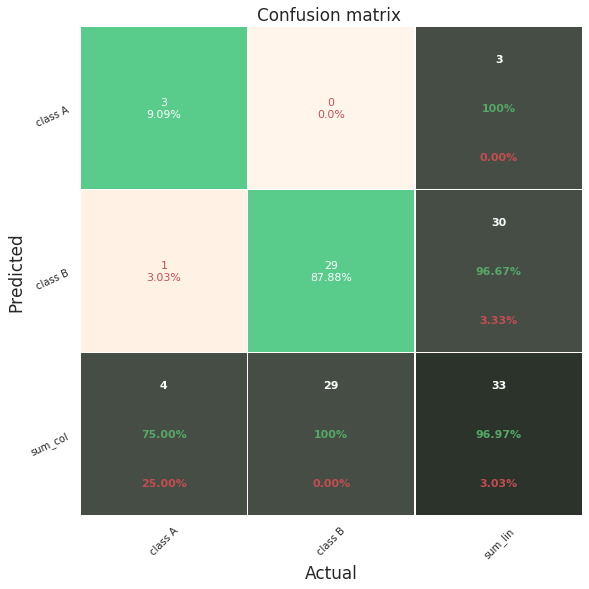

In [46]:
som = MiniSom(8,8, 384, sigma=3, learning_rate=0.05, 
              neighborhood_function='triangle', random_seed=10)

# I am goig to initialise weights of som using pca so as to make convergence faster
som.pca_weights_init(X_train.values)
som.train_random(X_train.values, 5000, verbose=False)
class_labels = som.labels_map(X_train.values, y_train.values)
y_pred =classify(som,X_test.values,class_labels)
prt.plot_confusion_matrix_from_data(y_test,predictions=y_pred)

# Naive Bayes

In [91]:
def nb_cv(*args,X,y,trainfolds):
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=MultinomialNB(),
        param_grid={
            "alpha":np.linspace(0,1,num=50),
            "fit_prior":[True,False]
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =[]
    coefficients =grid_result.best_estimator_.coef_[0]
    

    return (best_params,grid_result,coefficients)

In [96]:
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.Water]*3
ygrouplist = [wwfdf.Area_group]*3

# Rivers as labels
# ysetlist = [wwfdf.river_label]*3
# ygrouplist= [wwfdf.river_label]*3
#scaler = FeatureAgglomeration(n_clusters=100)
resampler = RandomOverSampler(random_state=11235)
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

# scaler = None#TfidfTransformer()
# riv_xgb_rand =mth.runningsplittest(StratifiedKFold,xgb_rcv,index,xsetlist,ysetlist,ygrouplist= ygrouplist)
dis_mnb_riv_ros =mth.runningsplittest(GroupKFold,nb_cv,index,xsetlist,ysetlist,resampler=resampler,ygrouplist= ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler


ValueError: Found input variables with inconsistent numbers of samples: [248, 132, 132]

In [44]:
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
ysetlist = [wwfdf.Water]*3
ygrouplist =  [wwfdf.Area_group]*3

# Rivers as labels
# ysetlist = [wwfdf.river_label]*3
#ygrouplist= [wwfdf.river_label]*3
scaler = prepro.StandardScaler(with_mean=False)

# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

#scaler = None#TfidfTransformer()
# riv_xgb_rand =mth.runningsplittest(StratifiedKFold,xgb_rcv,index,xsetlist,ysetlist,ygrouplist= ygrouplist)
dis_mnb_full_sc =mth.runningsplittest(GroupKFold,nb_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 8  5]
 [ 5 14]]
1
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 30]]
2
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  1]
 [ 5 21]]
3
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [19  5]]
4
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [11  8]]
5
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 3]
 [6 5]]
6
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 2 10]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 6  7]
 [ 2 17]]
1
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 1 31]]
2
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  1]
 [ 1 25]]
3
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  5]
 [ 0 11]]
6
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  9]
 [ 1 18]]
1
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  2]
 [ 0 26]]
3
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  4]
 [ 0 11]]
6
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.7s


[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [66]:
# Dissimilarity full100s dataframe
index = ["FULL100s","FULL100s CSS","FULL100s CSS LOG"]
xsetlist = [fullotudf100s,fullotudf100sCss,fullotudf100sCssLog]
ysetlist = [wwfdf.loc[full_s_ind,"Water"]]*3
ygrouplist =  [wwfdf.loc[full_s_ind,"Area_group"]]*3

scaler = None
dis_bnb_full100s =mth.runningsplittest(GroupKFold,nb_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.4s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2 11]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[5 0]
 [6 5]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2 11]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[5 0]
 [6 5]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2 11]
 [ 1 17]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 22]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.5s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0]
 [ 2 17]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[5 0]
 [6 5]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    0.8s


[[ 0  0]
 [ 0 12]]


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [50]:
# Location classification
ysetlist = [wwfdf.loc[:,"location_labels"]]*3
index = ["FULL","FULL CSS","FULL CSS LOG"]
xsetlist = [fullotudf,fullotudfCss,fullotudfCssLog]
loc_bnb_full = mth.runningsplittest(StratifiedKFold,nb_cv,index,xsetlist,ysetlist)

#ysetlist = [wwfdf.loc[full_s_ind,"river_label"]]*3
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
loc_bnb_riv = mth.runningsplittest(StratifiedKFold,nb_cv,index,xsetlist,ysetlist)

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  7  0]
 [ 0  0 13]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  1 12]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 4  3  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  4  3]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0]
 [0 6 0]
 [0 4 9]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  7  0]
 [ 0  0 13]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  1 12]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 4  3  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  4  3]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0]
 [0 6 0]
 [0 4 9]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  7  0]
 [ 0  0 13]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  1 12]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 4  3  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  4  3]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    1.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0]
 [0 6 0]
 [0 4 9]]
Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  5  2]
 [ 0  1 12]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  0 13]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 2  5  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  2  5]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0]
 [0 5 1]
 [0 5 8]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  5  2]
 [ 0  1 12]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  0 13]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 2  5  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  2  5]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0]
 [0 5 1]
 [0 5 8]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  4]
 [ 0  7  0]
 [ 0 12  2]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  3]
 [ 0  5  2]
 [ 0  1 12]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 4  0  0]
 [ 0  7  0]
 [ 0  0 13]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 2  5  0]
 [ 0  0 13]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  2  5]
 [ 0  0 13]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0]
 [ 0  3  4]
 [ 0  0 13]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits
[[3 0 0]
 [0 5 1]
 [0 5 8]]


[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    0.7s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# XGBoost

In [303]:
def xgb_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",learning_rate=0.2),
        param_grid={
            'max_depth': range(1,3),
            'n_estimators': [500,600],
            "min_child_weight":range(1,3)
            #"reg_alpha":[0,0.3,0.7,1],
            #"reg_lambda":[0,0.3,0.7,1]
            
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [311]:
def xgb_rcv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = RandomizedSearchCV(
        estimator=xgb.XGBClassifier(objective="binary:logistic",n_estimators=500),random_state = 42,
        param_distributions={
            'max_depth': range(2,4),
            "min_child_weight":range(1,3),
            "gamma": st.uniform(loc=0,scale=1),
            "reg_alpha":st.uniform(loc=0,scale =1),
            "reg_lambda":st.uniform(loc=0,scale=1)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False,n_iter = 100)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    coefficients =grid_result.best_estimator_.feature_importances_
    

    return (best_params,grid_result,coefficients)

In [313]:
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.Water]*3
ygrouplist = [wwfdf.Area_group]*3
# riv_xgb_rand =mth.runningsplittest(StratifiedKFold,xgb_rcv,index,xsetlist,ysetlist,ygrouplist= ygrouplist)
dis_xgb_rand =mth.runningsplittest(GroupKFold,xgb_rcv,index,xsetlist,ysetlist,ygrouplist= ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.0min finished


[[ 1 12]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 1  0]
 [ 1 18]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished


[[ 0  0]
 [ 1 11]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   57.4s finished


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 0  1]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 12]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   57.0s finished


[[ 0 13]
 [ 0 19]]
1
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 32]]
2
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


[[ 0  2]
 [ 0 26]]
3
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0]
 [ 0 24]]
4
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 0  1]
 [ 0 19]]
5
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished


[[ 0  5]
 [ 0 11]]
6
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
Fitting 6 folds for each of 100 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.2min finished


[[ 0  0]
 [ 0 12]]


/home/adamingas/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [ ]:
# index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
# xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
# ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
index = ["OTU CSS LOG"]
xsetlist = [otudfCssLog]
ysetlist = [wwfdf]

dissim_xgb_grid =runningsplittest(GroupKFold,xgb_cv,index,xsetlist,ysetlist)

# KNN

In [ ]:
def knn_cv(*args,X, y,trainfolds):
    """
    Function performs Grid search Cross validation for random forrests with trainfolds as folds generator. 
    Inputs:
    X: Train set
    y: Test set 
    trainfolds: CV folds generator
    Returns:
    best_params: Best parameters of the CV procedure
    grid_result: The output of the GridSearchCV method when fitted to
                 X and y
    """
    print(args)
    knnmetric = args[0]["metric"]
    if trainfolds ==None:
        foldscv = StratifiedKFold(n_splits=5,random_state=11235)
        trainfolds =foldscv.split(X,wwfdf.Area_group.loc[X.index])
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=KNeighborsClassifier(metric=knnmetric),
        param_grid={
        "n_neighbors": range(1,30),
       #,"braycurtis"],
            "weights":["uniform","distance"],
            "p": range(1,6)
        },
        cv=trainfolds, scoring = ["accuracy"], verbose=1, 
        n_jobs=-1,refit = "accuracy",return_train_score = False)
    #  Grid result is the output of the gridsearchcv
    # best_params are the parameters of the highest scoring algorithm
    # coefficients are the weights of the fetures which signify which one is important
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    

    return (best_params,grid_result,None)

In [113]:
def objective_knn(hyperparameters,X,y,trainfolds,knnmetric):
    """Objective function for logistic regression"""
    model = Pipeline([("resampler",BorderlineSMOTE(random_state=11235)),("KNN",KNeighborsClassifier(metric = knnmetric))])
    model.set_params(**hyperparameters)
#     logmodel = KNeighborsClassifier(metric = knnmetric).set_params(**hyperparameters)
    
    score = cross_val_score(model,X,y,cv=trainfolds,scoring="accuracy",n_jobs = -1)
    best_score = score.mean()
    loss = 1-best_score
    return {"loss":loss,"params":hyperparameters,"status":STATUS_OK}

In [121]:
def knn_bcv(*args,X,y,trainfolds,**kwargs):
    """
    Bayesian optiisation of LogisticRegression
    """
    try:
        knnmetric = args[0]["metric"]
    except KeyError:
        knnmetric = "minkowski"
    trainfoldlist = list(trainfolds)
    bayes_trials = Trials()
    MAX_EVALS = 300
    # Define the search space
    space = {
    "KNN__n_neighbors" : hp.choice("KNN__n_neighbors",list(np.arange(1,50))),
    "resampler__k_neighbors" : hp.choice("resampler__k_neighbors",list(np.arange(1,9))),
    "resampler__m_neighbors" : hp.choice("resampler__m_neighbors",list(np.arange(8,13))),

    "resampler__kind" : hp.choice("resampler__kind",["borderline-1","borderline-2"])
    }

    # Optimize
    best = fmin(fn =lambda x: objective_knn(x,X=X,y=y,trainfolds=trainfoldlist,knnmetric = knnmetric), space = space, algo = tpe.suggest, 
                max_evals = MAX_EVALS, trials = bayes_trials,return_argmin=False)
    print(best)
    model =Pipeline([("resampler",BorderlineSMOTE(random_state=11235)),("KNN",KNeighborsClassifier(metric = knnmetric))]).set_params(**best)
    fitted_model=model.fit(X,y)
    
    return(best,fitted_model,[])

In [122]:
# Rivers as labels
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
ysetlist = [wwfdf.river_label]*3

#resampler = BorderlineSMOTE(random_state = 11235,kind = "borderline-2",n_jobs =-1)
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

riv_knn_riv_smote_bay = mth.runningsplittest(StratifiedKFold,knn_bcv,index,xsetlist,ysetlist)
# resampler = ADASYN(random_state = 11235,n_jobs =-1)
# riv_knn_riv_adasyn= mth.runningsplittest(StratifiedKFold,mth.knn_cv,index,xsetlist,ysetlist,resampler=resampler)
# resampler = RandomOverSampler(random_state=11235)
# riv_knn_riv_ros= mth.runningsplittest(StratifiedKFold,mth.knn_cv,index,xsetlist,ysetlist,resampler=resampler)

Using class labels as groupping variables. To choose a different groupping   set pass a list of the variables to groupby. Pass the list to ygrouplist
Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [00:20<00:00, 16.60it/s, best loss: 0.3067632850241545] 
{'KNN__n_neighbors': 4, 'resampler__k_neighbors': 1, 'resampler__kind': 'borderline-1', 'resampler__m_neighbors': 8}
[[2 0 0 1]
 [0 4 0 0]
 [7 0 4 0]
 [4 0 0 2]]
1
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 

100%|██████████| 300/300 [00:17<00:00, 16.33it/s, best loss: 0.21678743961352664]
{'KNN__n_neighbors': 28, 'resampler__k_neighbors': 4, 'resampler__kind': 'borderline-1', 'resampler__m_neighbors': 9}
[[3 0 0 0]
 [0 3 0 0]
 [1 0 7 3]
 [0 0 1 5]]
4
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [00:18<00:00, 16.32it/s, best loss: 0.18297101449275377]
{'KNN__n_neighbors': 1, 'resampler__k_neighbors': 1, 'resampler__kind': 'borderline-1', 'resampler__m_neighbors': 8}
[[2 0 0 1]
 [0 3 0 0]
 [1 2 8 0]
 [1 0 2 3]]
5
No resampling is performed on the data. To change it pass a resampling method from the imbalanced learn library
The identity scaler is used. To change it pass a preprocessing class  with the variable scaler
100%|██████████| 300/300 [00:18<00:00, 16.18it/s, best loss: 0.2403381642512078]
{'KNN__n_nei

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

dis_knn_min_grid_fish =runningsplittest(GroupKFold,knn_cv,index,xsetlist,ysetlist,metric="minkowski")

In [ ]:
index = ["Fish","Fish CSS","Fish CSS LOG"]
xsetlist = [fishdf,fishdfCss,fishdfCssLog]
ysetlist = [wwfdffish,wwfdffish,wwfdffish]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid_fish =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist,knnmetric="minkowski")

In [ ]:
def test(a,b,**kwarg):
    test2(kwarg,w=a)
def test2(*args,w):
    print(w,args[0])


In [ ]:
test(a=1,b= 4,metric=5)

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_min_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG","OTU LOW COR"]
xsetlist = [otudf,otudfCss,otudfCssLog,otudfLow]
ysetlist = [wwfdf,wwfdf,wwfdf,wwfdf]
#index = ["OTU CSS LOG"]
#xsetlist = [otudfCssLog]
#ysetlist = [wwfdf]

sim_knn_bray_grid =runningsplittest(StratifiedKFold,knn_cv,index,xsetlist,ysetlist)

In [ ]:
dataset =dissim_knn_min_grid
print(dataset.Confusion)
print("\n")
print(dataset.Parameters[0])

In [ ]:
sim_knn_bray_grid.to_pickle("sim_knn_bray_grid")
#sim_knn_min_grid.to_pickle("sim_knn_min_grid")

# New heading

# VotingClassifier

In [26]:
def voting_cv(*args,X,y,trainfolds):
    """
    Combining a number of classifiers to get their benefits
    First we cros validate them separately on the trainfoldslist. Then we pick the best set of hyperparameters
    Notice we do not minimise the train error rate but rather choose the best hyperparameters
    over the trainfoldslist. Finally, we pass the hyperparameters of these classifiers to the voting classifier
    which is cross validated over the weights assigned to each classifier.
    """
    # Converting generator to list
    trainfoldslist = list(trainfolds)
    
    voting =RandomizedSearchCV(
    estimator= VotingClassifier(estimators =
                [("svm",SVC()),("MNB",MultinomialNB()),("KNN",KNeighborsClassifier())])
    ,param_distributions={
        "svm__kernel":["poly"],"svm__gamma":["auto","scale",0.1,1,10],"svm__class_weight":["balanced",None],
                    'svm__C':[0.1, 1, 0.5], "svm__degree":[1,2],"svm__coef0" :[0,0.1,1,0.001],"MNB__alpha":np.linspace(0,0.9,num=30),
            "MNB__fit_prior":[True,False],"KNN__n_neighbors": range(1,30),
            "KNN__weights":["uniform","distance"],
            "KNN__p": range(1,6),
        "weights": [[1,1,1],[1,1,2],[1,2,1],[2,1,1],[1,1,3],[1,3,1],[3,1,1]]
    }
        ,cv=trainfoldslist, scoring = ["accuracy"], verbose=-1, n_jobs=-1,refit = "accuracy",n_iter=1500,
        return_train_score = False)
    grid_result =voting.fit(X,y)
    try:
        best_params = grid_result.best_params_
    except AttributeError:
        best_params = {**knn_params,**mnb_params,**svm_params}
    

    return (best_params,grid_result,None)


In [30]:
def voting_svm_rfr_log_cv(*args,X,y,trainfolds):
    """
    Combining a number of classifiers to get their benefits
    First we cros validate them separately on the trainfoldslist. Then we pick the best set of hyperparameters
    Notice we do not minimise the train error rate but rather choose the best hyperparameters
    over the trainfoldslist. Finally, we pass the hyperparameters of these classifiers to the voting classifier
    which is cross validated over the weights assigned to each classifier.
    """
    # Converting generator to list
    trainfoldslist = list(trainfolds)
    
    voting =RandomizedSearchCV(
    estimator= VotingClassifier(voting = "soft",estimators =
                [("svm",SVC(probability = True)),("RFR",RandomForestClassifier()),("LR",LogisticRegression(penalty="l2"))])
    ,param_distributions={
        "svm__kernel":["poly"],"svm__gamma":["auto","scale",0.1,1,10],"svm__class_weight":["balanced",None],
                    'svm__C':[0.1, 1, 0.5], "svm__degree":[1,2],"svm__coef0" :[0,0.1,1,0.001],
        "LR__C": [0.0001,0.001,0.01,0.1,50] + list(np.arange(1,20,2)),
        'RFR__max_depth':(list(range(3,7))+[None]),
            'RFR__n_estimators': [100,300,500,1000],
            "RFR__min_samples_split":[2,3,4],
            "RFR__class_weight" : ["balanced"],
            "RFR__bootstrap": [False],
        "weights": [[1,1,1],[1,1,2],[1,2,1],[2,1,1],[1,1,3],[1,3,1],[3,1,1]]
    }
        ,cv=trainfoldslist, scoring = ["accuracy"], verbose=-1, n_jobs=-1,refit = "accuracy",n_iter=1500,
        return_train_score = False)
    grid_result =voting.fit(X,y)
    try:
        best_params = grid_result.best_params_
    except AttributeError:
        best_params = {**knn_params,**mnb_params,**svm_params}
    

    return (best_params,grid_result,None)


In [31]:
index = ["RIVER","RIVER CSS","RIVER CSS LOG"]
xsetlist = [riverdf,riverdfCss,riverdfCssLog]
# ysetlist = [wwfdf.Water]*3
# ygrouplist = [wwfdf.Area_group]*3

# Rivers as labels
ysetlist = [wwfdf.river_label]*3
ygrouplist= [wwfdf.river_label]*3
#scaler = FeatureAgglomeration(n_clusters=100)
scaler = prepro.StandardScaler(with_mean=False)
# index = ["RIVER100s","RIVER100s CSS","RIVER100s CSS LOG"]
# xsetlist = [riverdf100s,riverdf100sCss,riverdf100sCssLog]
# ysetlist = [wwfdf.loc[river_s_ind,"river_label"]]*3
# ygrouplist =  [wwfdf.loc[river_s_ind,"Area_group"]]*3

# scaler = None#TfidfTransformer()
# riv_xgb_rand =mth.runningsplittest(StratifiedKFold,xgb_rcv,index,xsetlist,ysetlist,ygrouplist= ygrouplist)
riv_vote_svm_rfr_log_soft_riv_sc =mth.runningsplittest(StratifiedKFold,voting_svm_rfr_log_cv,index,xsetlist,ysetlist,scaler=scaler,ygrouplist= ygrouplist)

Using the same groupping svariable in the validation split
0
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.6min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change 

[[3 0 0 0]
 [0 4 0 0]
 [0 0 3 8]
 [0 0 2 4]]
1


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
2


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[3 0 0 0]
 [0 4 0 0]
 [0 3 6 2]
 [0 0 2 4]]
3


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.6min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  3  3]]
4


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[2 0 0 1]
 [0 3 0 0]
 [0 1 9 1]
 [0 0 4 2]]
5


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 1  0  2  3]]
1
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[1 0 1 1]
 [0 4 0 0]
 [0 0 7 4]
 [0 0 3 3]]
1


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
2


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[3 0 0 0]
 [0 4 0 0]
 [0 4 7 0]
 [0 0 0 6]]
3


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
4


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.9min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
5


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]
6


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  0  6]]
2
Same CV generator as train-test split. To change it set cvgenerator2 to StratifiedKFold or GroupKFold
0


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.6min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  Depreca

[[2 0 1 0]
 [0 0 4 0]
 [0 0 3 8]
 [0 0 2 4]]
1


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 3  0  0  0]
 [ 0  4  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
2


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[3 0 0 0]
 [0 4 0 0]
 [0 4 5 2]
 [1 0 2 3]]
3


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.7min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change 

[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  3  3]]
4


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
5


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.9min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  0  6]]
6


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 3512 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 8696 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed: 13.8min finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will ch

[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]


/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


# Parts of Rivers as labels

Changing labels of prediction to parts of river. So we have a multiclass problem

Trying KNN. We will be using the methods files

In [37]:
mth = importlib.reload(mth)

In [38]:
index = ["OTU"]#,"OTU CSS","OTU CSS LOG"]
xsetlist = [otudf]#,otudfCss,otudfCssLog]
ysetlist =[wwfdf.river_label]#,wwfdf.river_label,wwfdf.river_label]
# mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.knn_cv,xsetlist=xsetlist,ysetlist=ysetlist)
riv_knn_bray = mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.knn_cv,xsetlist=xsetlist,ysetlist=ysetlist,metric="braycurtis")

0
Same CV generator as train-test split
0
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    4.6s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [2 0 6 3]
 [3 0 0 3]]
1
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.0s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[2 0 0 1]
 [0 4 0 0]
 [1 0 9 1]
 [0 0 0 6]]
2
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 340 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 4 7 0]
 [1 0 1 4]]
3
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 3 0 0]
 [3 0 5 3]
 [3 0 1 2]]
4
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[1 0 0 2]
 [0 3 0 0]
 [0 0 7 4]
 [0 0 0 6]]
5
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 2  0  1  3]]
6
({'metric': 'braycurtis'},)
Fitting 6 folds for each of 290 candidates, totalling 1740 fits


[Parallel(n_jobs=-1)]: Done 412 tasks      | elapsed:    1.0s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]


[Parallel(n_jobs=-1)]: Done 1740 out of 1740 | elapsed:    3.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Random Forrest 

In [7]:
index = ["OTU","OTU CSS","OTU CSS LOG"]
xsetlist = [otudf,otudfCss,otudfCssLog]
ysetlist =[wwfdf.river_label,wwfdf.river_label,wwfdf.river_label]
# mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.knn_cv,xsetlist=xsetlist,ysetlist=ysetlist)
riv_rfr = mth.runningsplittest(foldgenerator=StratifiedKFold,index=index,model_cv=mth.rfr_cv,xsetlist=xsetlist,ysetlist=ysetlist)

0
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    8.8s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[0 0 3 0]
 [0 0 4 0]
 [0 0 8 3]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  5  1]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [0 0 3 3]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.3s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 0  0 10  1]
 [ 0  0  3  3]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  0  2]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  1  5]]
1
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 2 0]
 [0 0 4 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  6  0]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [1 0 1 4]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  3  3]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 0  0  2  1]
 [ 0  2  1  0]
 [ 0  0 11  0]
 [ 0  0  3  3]]
2
Same CV generator as train-test split
0
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[1 0 2 0]
 [0 0 4 0]
 [0 0 9 2]
 [0 0 3 3]]
1
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[ 2  0  0  1]
 [ 0  1  3  0]
 [ 0  0 11  0]
 [ 0  0  6  0]]
2
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.1s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[[3 0 0 0]
 [0 4 0 0]
 [0 2 9 0]
 [0 0 4 2]]
3
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 3  0  0  0]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  4  2]]
4
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 1  0  1  1]
 [ 0  3  0  0]
 [ 1  0 10  0]
 [ 0  0  5  1]]
5
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[[ 2  0  0  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  4  2]]
6
Fitting 6 folds for each of 16 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s


[[ 0  0  2  1]
 [ 0  3  0  0]
 [ 0  0 11  0]
 [ 0  0  2  4]]


[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:    7.2s finished
/home/adamingas/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Opening dataframes

## Functions

In [28]:
#  dissim_logl1_riv_saga =pd.read_pickle("dis_logl1_df_river_saga")
#dissim_rfr_df = pd.read_pickle("dis_rfr")
# sim_log_df = pd.read_pickle("sim_log")
# sim_rfr_df= pd.read_pickle("sim_rf")
# rand_rfr_df = pd.read_pickle("rand_rfr")
# rand_log_df = pd.read_pickle("rand_log")
# sim_log
# l2_df =pd.read_pickle("sim_logl2_df")
# dissim_logl2_df =pd.read_pickle("dissim_logl2_df")
# dissim_knn_bray_grid = pd.read_pickle("dissim_knn_bray_grid")
# dissim_knn_min_grid = pd.read_pickle("dissim_knn_min_grid")
# sim_knn_min_grid = pd.read_pickle("sim_knn_min_grid")
sim_knn_bray_grid = pd.read_pickle("models/predictions/loc_rfr_rivcsslog_smote2")
riv_bnb_full =pd.read_pickle("models/predictions/riv_bnb_full")
dis_mnb_riv =pd.read_pickle("models/predictions/dis_mnb_riv")
#dis_rfr_riv =pd.read_pickle("models/predictions/dis_rfr")
dis_logl2_riv_sc =pd.read_pickle("models/predictions/dis_logl2_riv_sc")

In [25]:
def confusionvisualisation(dataframe,fname=None,title="",water=False):
    """
    Input:
    Dataframe: A pandas dataframe of results from runningsplittest
    Output:
    A plot of confusion matrix"""
    #sns.set(font_scale=1)#for label size
    fig,ax = plt.subplots(nrows=3,ncols=1,figsize = (5,20),constrained_layout=True)
    #fig2 = plt.figure()

    for j,i in enumerate(dataframe.Confusion):
        print(dataframe.index[j])
        if i.shape == (3,3):
            df_cm = pd.DataFrame(i, index = ["UMar","MMar,Tap","LMar,Nap,Hua"],
                             columns=["UMar","MMar,Tap","LMar,Nap,Hua"]) 
        elif i.shape == (4,4):
            df_cm = pd.DataFrame(i, index = ["Black","UMar","MLMar,Uc","Tap,Nap,Hua"],
                             columns=["Black","UMar","MLMar,Uc","Tap,Nap,Hua"])
        else:
            df_cm = pd.DataFrame(i, index = ["Black","White"],
                             columns= ["Black","White"])
        prt.pretty_plot_confusion_matrix(df_cm,axis = ax[j],title = dataframe.index[j],pred_val_axis="x")
        #plt.figure(figsize = (10,7))
#         plt.title(dataframe.index[j])
#         sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},cmap =sns.cm.rocket_r)
#         plt.xlabel("Predicted")
#         plt.ylabel("True")
#         plt.show()
    fig.suptitle(title, fontsize=25)
    if fname:
        fig.savefig(fname,dpi = 300)
    plt.show()
    #plt.savefig("test.png")

In [ ]:
def zero_params(x):
    zeroes =[]
    for i in x:
        zeroes.append((i == 0).sum()/i.shape[1] )
    zeroes = np.array(zeroes).mean()
    return(zeroes)
dataframe = dissim_log_df
dataframe.Coefficients.apply(lambda x:zero_params(x))
    

In [ ]:
index = ["OTU","OTU CSS","OTU CSS LOG"]

acv_coef =[]
for k in range(7):
    first_coef =[]
    for i in dissim_log_df.Coefficients[index]:
        #print(i)
        first_coef.append((i[k]==0.0)*1)
    commonz=[]  
    for j in range(first_coef[0].shape[1]):

        commonz.append(np.all(first_coef[0][0,j] == first_coef[1][0,j]==first_coef[2][0,j] == 0))
    acv_coef.append( np.array(commonz).mean())
np.array(acv_coef).mean()


In [ ]:
dataframe = dissim_baysl2

for j,i in enumerate(dataframe.Confusion):
    print(dataframe.index[j])
    print(i)
    acc = (i[0,0]+i[1,1])/i.sum()
    print(round(acc,4))

## LR

In [73]:
display(Markdown("### LR DIS L1 all otu, standards scaler"))
printoutdataframe( dis_logl1_standscale)

### LR DIS L1 all otu, standards scaler

OTU
[[  3.  18.]
 [  8. 135.]]
0.8415
[{'C': 1}, {'C': 0.1}, {'C': 1}, {'C': 5}, {'C': 1}, {'C': 0.1}, {'C': 10}]
OTU CSS
[[  6.  15.]
 [ 13. 130.]]
0.8293
[{'C': 1}, {'C': 5}, {'C': 1}, {'C': 20}, {'C': 1}, {'C': 50}, {'C': 1}]
OTU CSS LOG
[[  6.  15.]
 [  1. 142.]]
0.9024
[{'C': 0.1}, {'C': 0.1}, {'C': 10}, {'C': 10}, {'C': 0.1}, {'C': 1}, {'C': 5}]


In [77]:
display(Markdown("### LR DIS L1 all otu, standards scaler with mean false"))
printoutdataframe( dis_logl1_standscalemeanf)

### LR DIS L1 all otu, standards scaler with mean false

OTU
[[  4.  17.]
 [ 11. 132.]]
0.8293
[{'C': 50}, {'C': 1}, {'C': 20}, {'C': 50}, {'C': 5}, {'C': 0.1}, {'C': 10}]
OTU CSS
[[  5.  16.]
 [ 11. 132.]]
0.8354
[{'C': 0.1}, {'C': 5}, {'C': 1}, {'C': 1}, {'C': 50}, {'C': 50}, {'C': 1}]
OTU CSS LOG
[[  8.  13.]
 [  2. 141.]]
0.9085
[{'C': 1}, {'C': 0.1}, {'C': 10}, {'C': 1}, {'C': 20}, {'C': 50}, {'C': 20}]


In [89]:
display(Markdown("### LR DIs L1 all otu, min max"))
printoutdataframe( dis_logl1_minmax)

### LR DIs L1 all otu, min max

OTU
[[  1.  20.]
 [  9. 134.]]
0.8232
[{'C': 0.1}, {'C': 0.1}, {'C': 5}, {'C': 1}, {'C': 5}, {'C': 0.1}, {'C': 0.1}]
OTU CSS
[[  4.  17.]
 [  9. 134.]]
0.8415
[{'C': 0.1}, {'C': 5}, {'C': 5}, {'C': 10}, {'C': 20}, {'C': 1}, {'C': 5}]
OTU CSS LOG
[[  1.  20.]
 [  3. 140.]]
0.8598
[{'C': 0.1}, {'C': 10}, {'C': 50}, {'C': 10}, {'C': 20}, {'C': 0.1}, {'C': 50}]


In [91]:
display(Markdown("### LR DIs L1 all otu, max abs"))
printoutdataframe( dis_logl1_maxabs)

### LR DIs L1 all otu, max abs

OTU
[[  1.  20.]
 [  9. 134.]]
0.8232
[{'C': 0.1}, {'C': 0.1}, {'C': 5}, {'C': 1}, {'C': 5}, {'C': 0.1}, {'C': 0.1}]
OTU CSS
[[  4.  17.]
 [  9. 134.]]
0.8415
[{'C': 0.1}, {'C': 5}, {'C': 5}, {'C': 10}, {'C': 20}, {'C': 1}, {'C': 5}]
OTU CSS LOG
[[  1.  20.]
 [  3. 140.]]
0.8598
[{'C': 0.1}, {'C': 20}, {'C': 50}, {'C': 10}, {'C': 20}, {'C': 0.1}, {'C': 50}]


In [78]:
display(Markdown("### LR DIS L2 all otu, standard scaler with mean false"))
printoutdataframe( dis_logl2_standscalemeanf)

### LR DIS L2 all otu, standard scaler with mean false

OTU
[[  6.  15.]
 [  1. 142.]]
0.9024
[{'C': 1}, {'C': 1}, {'C': 1}, {'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}]
OTU CSS
[[  5.  16.]
 [  0. 143.]]
0.9024
[{'C': 0.1}, {'C': 0.1}, {'C': 0.1}, {'C': 1}, {'C': 0.1}, {'C': 1}, {'C': 0.1}]
OTU CSS LOG
[[  8.  13.]
 [  0. 143.]]
0.9207
[{'C': 0.1}, {'C': 20}, {'C': 50}, {'C': 5}, {'C': 20}, {'C': 1}, {'C': 20}]


In [75]:
display(Markdown("### LR DIS L2 all otu, standard scaler"))
printoutdataframe( dis_logl2_standscale)

### LR DIS L2 all otu, standard scaler

OTU
[[ 12.   9.]
 [ 25. 118.]]
0.7927
[{'C': 0.1}, {'C': 5}, {'C': 50}, {'C': 20}, {'C': 5}, {'C': 20}, {'C': 1}]
OTU CSS
[[ 14.   7.]
 [ 13. 130.]]
0.878
[{'C': 0.1}, {'C': 5}, {'C': 1}, {'C': 0.0001}, {'C': 5}, {'C': 1}, {'C': 0.1}]
OTU CSS LOG
[[ 15.   6.]
 [ 37. 106.]]
0.7378
[{'C': 5}, {'C': 0.001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 10}, {'C': 5}, {'C': 0.01}]


In [85]:
display(Markdown("### LR DIS L2 all otu, Robust scaler 0.25-0.95"))
printoutdataframe( dis_logl2_rs95)

### LR DIS L2 all otu, Robust scaler 0.25-0.95

OTU
[[ 13.   8.]
 [ 27. 116.]]
0.7866
[{'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}]
OTU CSS
[[ 11.  10.]
 [ 12. 131.]]
0.8659
[{'C': 0.01}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.01}]
OTU CSS LOG
[[ 10.  11.]
 [  1. 142.]]
0.9268
[{'C': 1}, {'C': 10}, {'C': 0.01}, {'C': 1}, {'C': 1}, {'C': 1}, {'C': 10}]


In [88]:
display(Markdown("### LR DIS L2 all otu, minmax"))
printoutdataframe( dis_logl2_minmax)

### LR DIS L2 all otu, minmax

OTU
[[  7.  14.]
 [  4. 139.]]
0.8902
[{'C': 50}, {'C': 5}, {'C': 5}, {'C': 50}, {'C': 10}, {'C': 20}, {'C': 10}]
OTU CSS
[[  7.  14.]
 [  1. 142.]]
0.9085
[{'C': 5}, {'C': 50}, {'C': 50}, {'C': 5}, {'C': 50}, {'C': 5}, {'C': 10}]
OTU CSS LOG
[[  5.  16.]
 [  0. 143.]]
0.9024
[{'C': 1}, {'C': 1}, {'C': 5}, {'C': 5}, {'C': 1}, {'C': 10}, {'C': 1}]


In [92]:
display(Markdown("### LR DIS L2 all otu, max abs"))
printoutdataframe( dis_logl2_maxabs)

### LR DIS L2 all otu, max abs

OTU
[[  7.  14.]
 [  4. 139.]]
0.8902
[{'C': 50}, {'C': 5}, {'C': 5}, {'C': 50}, {'C': 10}, {'C': 20}, {'C': 10}]
OTU CSS
[[  7.  14.]
 [  1. 142.]]
0.9085
[{'C': 5}, {'C': 50}, {'C': 50}, {'C': 5}, {'C': 50}, {'C': 5}, {'C': 10}]
OTU CSS LOG
[[  5.  16.]
 [  0. 143.]]
0.9024
[{'C': 1}, {'C': 1}, {'C': 5}, {'C': 5}, {'C': 1}, {'C': 10}, {'C': 1}]


In [137]:
display(Markdown("### LR DIS River saga and new CV grid"))
printoutdataframe( dis_logl2_df_river_saga)

### LR DIS River saga and new CV grid

OTU
[[  8.  13.]
 [ 15. 128.]]
0.8293
[{'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}]
OTU CSS
[[  3.  18.]
 [  7. 136.]]
0.8476
[{'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}, {'C': 0.0001}]
OTU CSS LOG
[[  5.  16.]
 [  0. 143.]]
0.9024
[{'C': 0.01}, {'C': 1}, {'C': 0.1}, {'C': 5}, {'C': 1}, {'C': 0.1}, {'C': 1}]


In [122]:
display(Markdown("### LR DIS L2"))
printoutdataframe( dis_logl2_df)

### LR DIS L2

OTU
[[  9.  12.]
 [ 15. 128.]]
0.8354
[{'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}]
OTU CSS
[[  3.  18.]
 [  7. 136.]]
0.8476
[{'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}]
OTU CSS LOG
[[  8.  13.]
 [  0. 143.]]
0.9207
[{'C': 1.001}, {'C': 4.0009999999999994}, {'C': 1.001}, {'C': 1.001}, {'C': 8.001}, {'C': 1.001}, {'C': 8.001}]


In [121]:
display(Markdown("### LR DIS"))
printoutdataframe( dis_logl2_df_river)

### LR DIS

OTU
[[  8.  13.]
 [ 15. 128.]]
0.8293
[{'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}]
OTU CSS
[[  3.  18.]
 [  7. 136.]]
0.8476
[{'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}, {'C': 0.001}]
OTU CSS LOG
[[  9.  12.]
 [  0. 143.]]
0.9268
[{'C': 1.001}, {'C': 1.001}, {'C': 1.001}, {'C': 2.001}, {'C': 1.001}, {'C': 1.001}, {'C': 1.001}]


RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


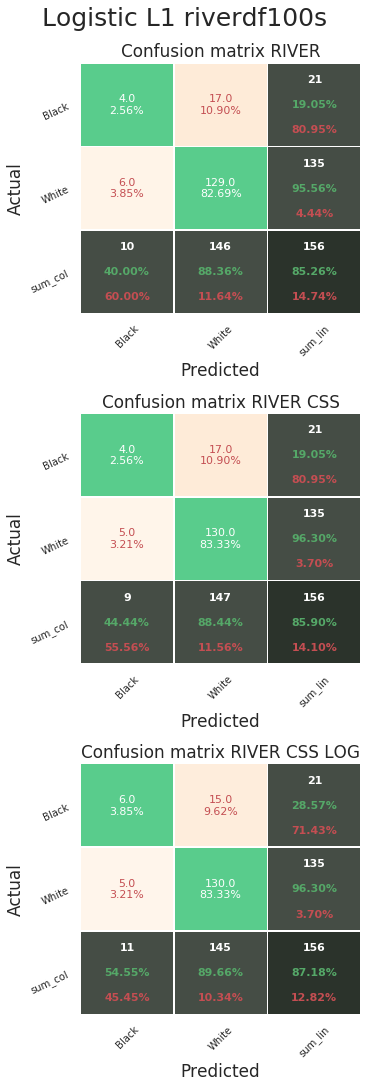

In [224]:
confusionvisualisation(dis_logl1_riv100s_sc,title="Logistic L1 riverdf100s")

RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


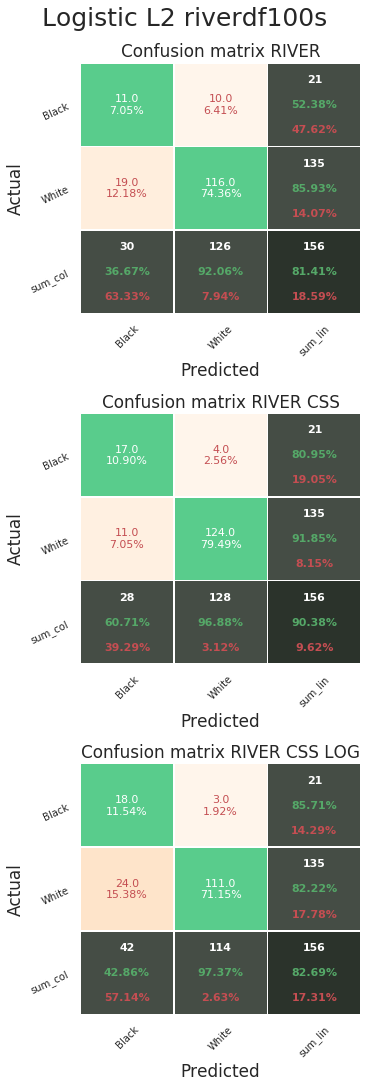

In [225]:
confusionvisualisation(dis_logl2_riv100s_sc
                       ,title="Logistic L2 riverdf100s")

## RFR

In [125]:
display(Markdown("### RFR DIS"))
#printoutdataframe( dis_rfr_df_balanced)
printoutdataframe( dis_rfr_df_balanced_otu)

### RFR DIS

OTU
[[  3.  18.]
 [ 10. 133.]]
0.8293
[{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 6, 'min_samples_split': 4, 'n_estimators': 300}]
OTU CSS
[[  7.  14.]
 [  2. 141.]]
0.9024
[{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 

In [123]:
display(Markdown("### RFR DIS"))
printoutdataframe( dis_rfr_df_balanced_river)


### RFR DIS

OTU
[[  5.  16.]
 [ 10. 133.]]
0.8415
[{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 300}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 500}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 1000}, {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 100}]
OTU CSS
[[  7.  14.]
 [  3. 140.]]
0.8963
[{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 300}, {'bootstrap': False, 'clas

OTU


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


OTU CSS
OTU CSS LOG


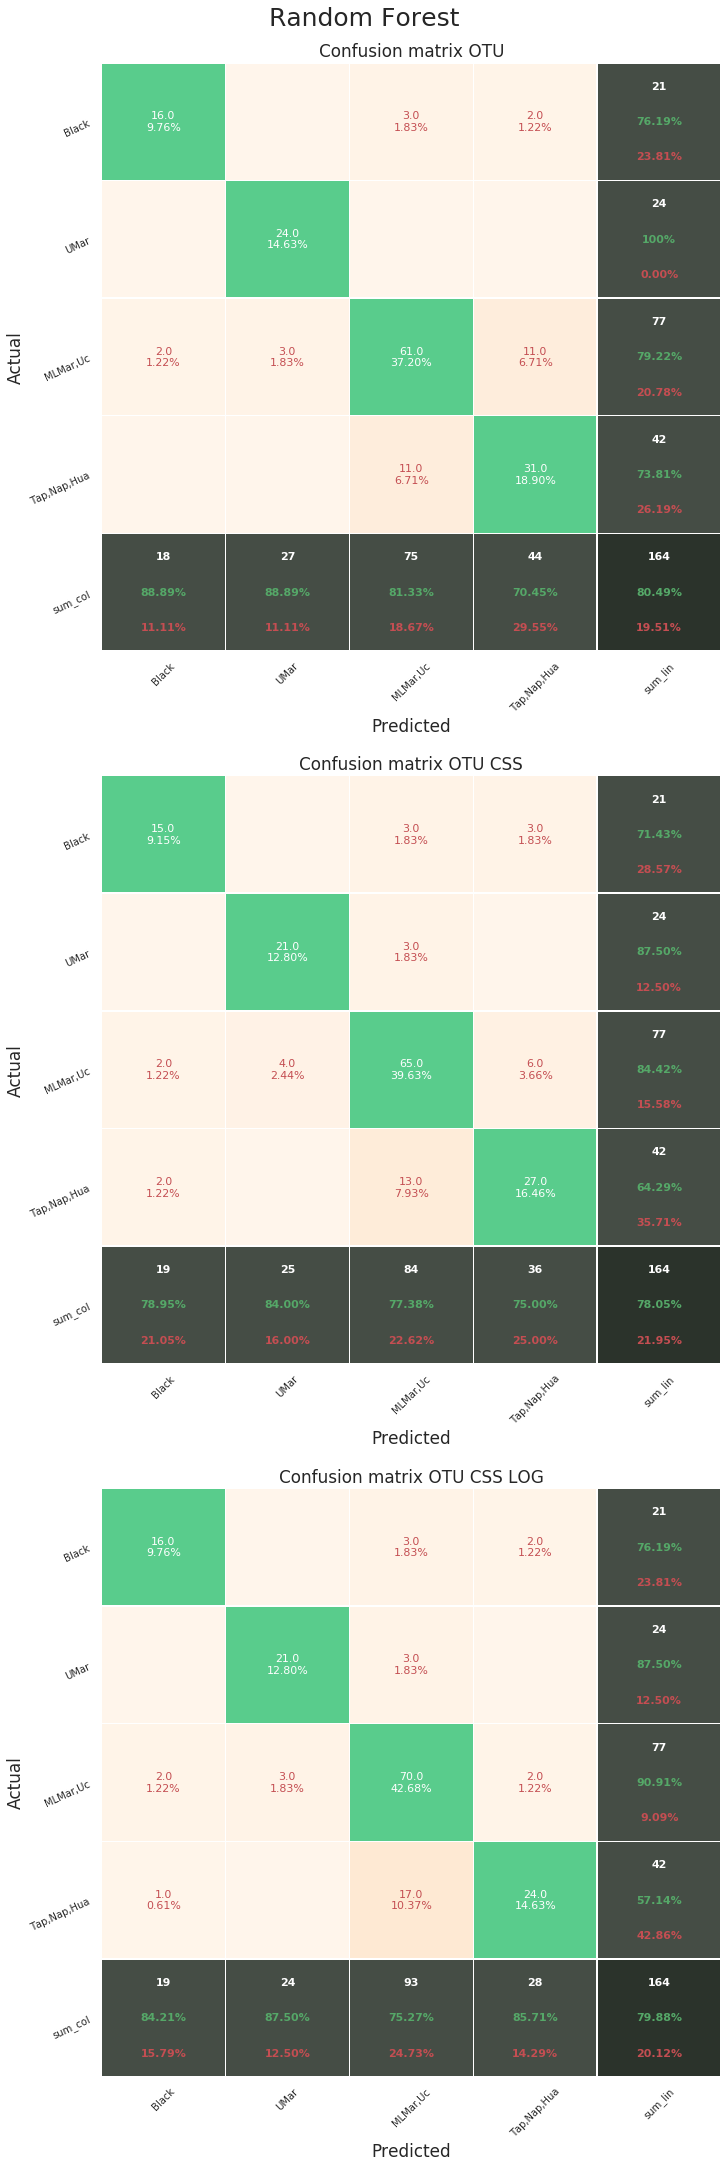

In [6]:
riverslabelvisualisation(riv_rfr_otu,title ="Random Forest")


RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


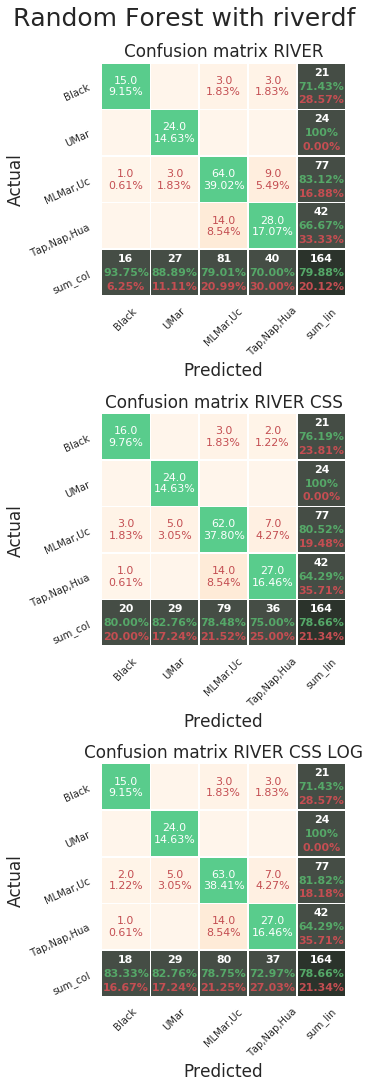

In [158]:
confusionvisualisation(riv_rfr_riv,title="Random Forest with riverdf")

RIVER100s


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER100s CSS
RIVER100s CSS LOG


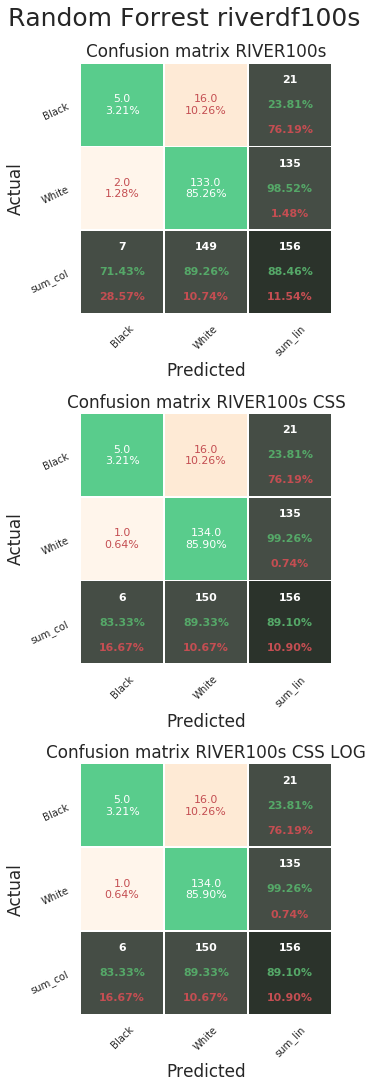

In [179]:

confusionvisualisation(dis_rfr_riv100s,title="Random Forrest riverdf100s")#prt.pretty_plot_confusion_matrix(riv_rfr_river.Confusion[0])

In [ ]:
display(Markdown("### RFR SIM"))
printoutdataframe( sim_rfr_fish)

## KNN

In [ ]:
display(Markdown("### KNN minkowski DIS"))
printoutdataframe( dis_knn_min_grid_fish)

In [ ]:
display(Markdown("### KNN minkowski SIM"))
printoutdataframe( sim_knn_min_grid_fish)

In [ ]:
display(Markdown("### KNN braycurtis DIS"))
printoutdataframe( dissim_knn_bray_grid)

In [ ]:
display(Markdown("### KNN bray SIM"))
printoutdataframe( sim_knn_min_grid)

In [183]:
riverslabelvisualisation(riv_knn)

NameError: name 'riv_knn' is not defined

knn bray

RIVER100s


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER100s CSS
RIVER100s CSS LOG


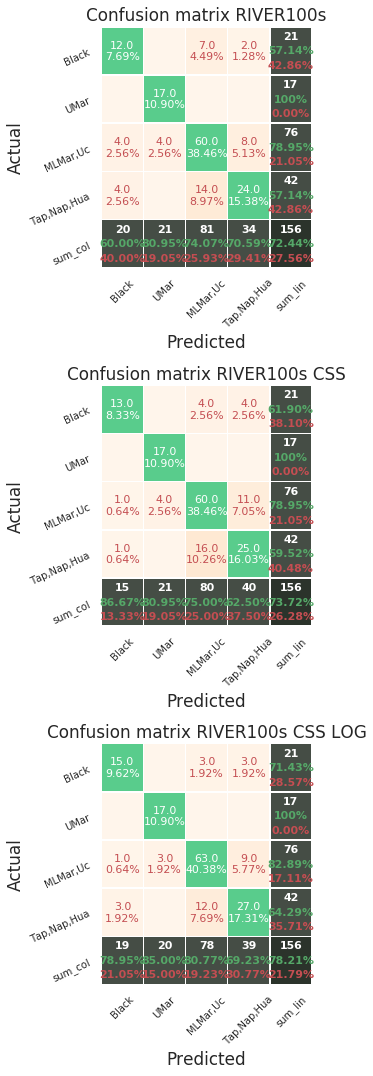

In [295]:
confusionvisualisation(riv_knn_riv100s)

## SVM

RIVER100s


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER100s CSS
RIVER100s CSS LOG


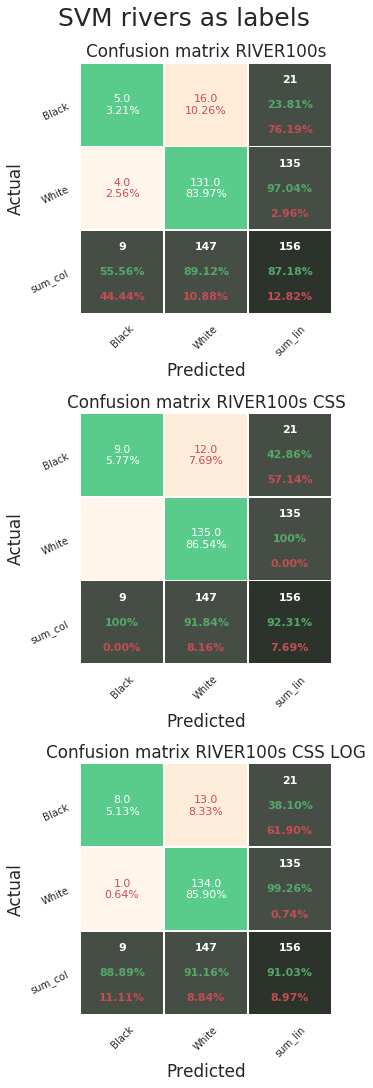

In [170]:
confusionvisualisation(dis_svm_riv100s_sc,water = True,title="SVM rivers as labels")

RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


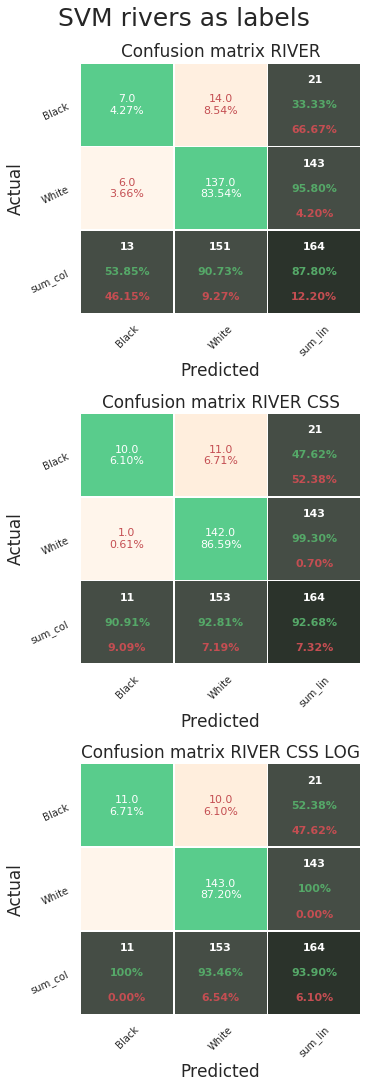

In [162]:
confusionvisualisation(dis_svm_riv_sc
                       ,water = True,title="SVM rivers as labels")

## NB

RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


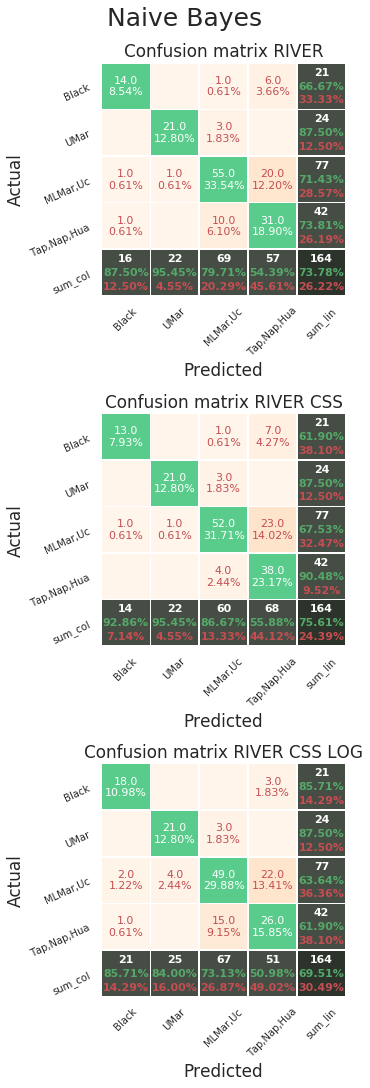

In [428]:
confusionvisualisation(riv_mnb_riv,title="Naive Bayes")

RIVER


/home/adamingas/amazon-rivers/prettyconfusion.py:170: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:172: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/home/adamingas/amazon-rivers/prettyconfusion.py:173: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False


RIVER CSS
RIVER CSS LOG


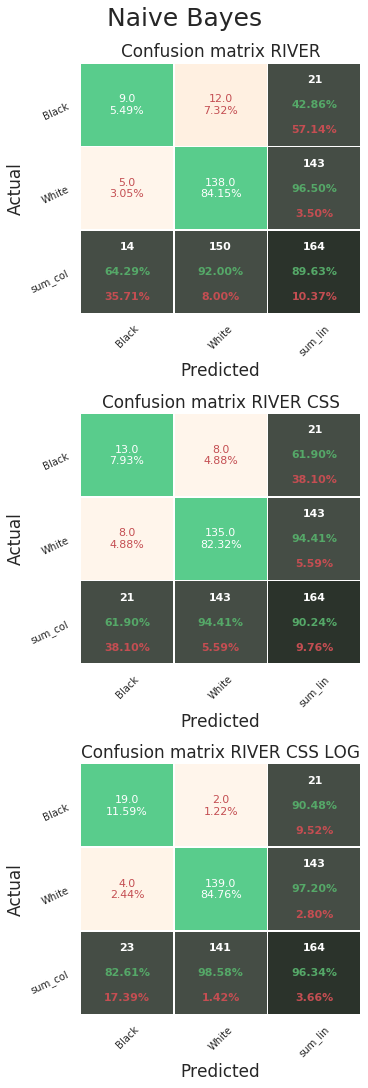

In [325]:
confusionvisualisation(dis_cnb_rand,title="Naive Bayes")

# Common Errors in samples

Here we check to see if some samples are consistently being missclassified among our classifiers. We first check dissimilarity.

In [167]:
wwfdf["FalseSamples"] = 0
for i in dis_mnb_riv.index:
    print(i)
    intersection =set(dis_logl2_riv_sc.FalseSamples[i])&set(dis_mnb_riv.FalseSamples[i])
    print(intersection)
    wwfdf.loc[intersection,"FalseSamples"] +=1
    print("length of intersection: ",len(intersection))
print(wwfdf.loc[wwfdf.FalseSamples>0,:].drop("Unnamed: 0",axis =1))
#(wwfdf.loc[wwfdf.FalseSamples>0,:].drop("Unnamed: 0",axis =1).to_csv("FalseSamples.csv"))

RIVER
{'2-S13C', '3-S10d', '2-S15A', '2-S15B', '2-S18D', '2-S15E'}
length of intersection:  6
RIVER CSS
{'2-S13C', '3-S10d', '3-S20d', '2-S16B', '2-S15E', '3-S08d'}
length of intersection:  6
RIVER CSS LOG
{'2-S13C', '2-S16D', '2-S16B', '3-S08a', '2-S17D'}
length of intersection:  5
        Easting  Northing                                            Details  \
ID                                                                             
2-S13C   520682   9497154  Cocha del R_Áo Chambira. Final de cocha. Desem...   
2-S15A   572640   9481435          Samiria. 3km hacia adentro. Aguas negras.   
2-S15B   574768   9482270        Samiria. 1.5km hacia adentro. Aguas negras.   
2-S15E   572827   9480405  Samiria. Quebrada Yanayaquillo. Desembocadura ...   
2-S16B   599390   9508184  R_Áo Tigre. Previo a R_Áo Nahuapa. Aguas blancas.   
2-S16D   599820   9508421                      R_Áo Tigre. Quebrada Nahuapa.   
2-S17D   633998   9485861                                  Boca de Yanayacu.

In [58]:
union =[]
false_samples_df = pd.DataFrame()
for i in ["OTU","OTU CSS","OTU CSS LOG"]:
    print(i)
    intersection =set(dis_logl2_df.FalseSamples[i]).intersection(dis_logl1_df.FalseSamples[i]).intersection(dis_rfr_df_balanced_otu.FalseSamples[i])
    union =set(union).union(intersection)
    print(union)
    print(len(union))
    print("length of intersection: ",len(intersection))
    print("errors per ")


OTU
{'3-S09c', '3-S14h', '3-S10d', '2-S18C', '2-S15B', '3-S20d', '2-S13A', '2-S15E', '2-S15C', '3-S14d', '3-S08d', '2-S15A'}
12
length of intersection:  12
errors per 
OTU CSS
{'2-S13C', '2-S18D', '2-S18B', '2-S15A', '3-S09c', '3-S14h', '3-S10d', '2-S18C', '2-S15B', '3-S20d', '2-S15E', '2-S15C', '3-S14d', '3-S08d', '2-S13B', '2-S13A'}
16
length of intersection:  12
errors per 
OTU CSS LOG
{'2-S13C', '2-S18D', '2-S18B', '2-S15A', '3-S09c', '3-S14h', '3-S10d', '2-S18C', '2-S15B', '3-S20d', '2-S15E', '2-S15C', '3-S14d', '3-S08d', '2-S13B', '2-S13A'}
16
length of intersection:  10
errors per 


In [151]:
union =[]
set(union).union(set([2,3]))

{2, 3}

# Taxa exploration

In [ ]:
index_of_coefficients =np.argsort(similarity_rfr_df.Coefficients["OTU"])
meancoefficients =np.array(similarity_rfr_df.Coefficients["OTU"]).mean(axis =0)
taxadf["Coefficients"] = meancoefficients
sum_per_class =taxadf.groupby(by = "Order").mean().sum()
(taxadf.groupby(by = "Order").mean()/sum_per_class).plot.pie(y = "Coefficients",figsize =(10,10))

In [138]:
#dataframe = diffsimilarity_rfr_df
def scaledtaxamethod(dataframe,average,taxon_level="Order",taxa = taxadf,index = ["OTU","OTU CSS","OTU MIN CSS","OTU CSS LOG"]):
    """
    Input
    dataframe: Dataframe from runningsplittest method
    """
    #taxon_level = "Order"
    taxa_dataf = taxa.copy()
    # get index of dataframe
    index = dataframe.index
    for i in index:
        mean_of_folds =np.abs(np.array(dataframe.Coefficients[i])).mean(axis =0)
        print(mean_of_folds.shape)
        taxa_dataf[i] = mean_of_folds
    # To change aggregate change the mean taxa by level. If its set to sum then it sums, if mean then the average is found
    if average == True:
        mean_taxa_by_level = taxa_dataf.groupby(by=taxon_level).mean()
    else:
        mean_taxa_by_level = taxa_dataf.groupby(by=taxon_level).sum()
    scaled_taxa_by_level =mean_taxa_by_level/mean_taxa_by_level.sum()
    return(scaled_taxa_by_level)

In [134]:
%matplotlib inline
def func(pct):
    if pct >=5:
        return "{:.1f}%".format(pct)
    else:
        return("")
def pieplots(scaled_taxa,ax_titles,filenameprefix):
    shape_of_df = scaled_taxa.shape
    colord =20
    scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%colord
    col_to_plot =scaled_taxa.columns
    #ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
    #fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))
    
    cmap = plt.get_cmap('tab20')
    colors = [cmap(i) for i in np.linspace(0,1,colord)]
    plt.rcParams.update({'font.size': 20})

    #axes.set_color_cycle(colors)
    for i,j in enumerate(col_to_plot):
        print(j)
        #ax = axes[i%3,i//3]
        fig = plt.figure(figsize=(10,10))
        ax = plt.axes()
        sortedindx = np.argsort(scaled_taxa[j])
        sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
        sortedlabels =scaled_taxa.index[sortedindx].values
        sortedlabels[0:-6] =""
        ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30, autopct=lambda pct: func(pct))
        ax.set_title(ax_titles[i],fontsize = 20)
        fig.savefig(fname=filenameprefix+j+".png",transparent=True,dpi=300)
        #scaled_taxa_by_level.plot.pie(y=i,legend =False,figsize=(10,10))
    #fig.suptitle(figure_title,fontsize=22,y=0.93)   
    #fig.subplots_adjust(wspace=0.01)
    #fig.savefig(figure_name,transparent=True,dpi = 300)

(384,)
(384,)
(384,)
OTU
OTU CSS
OTU CSS LOG


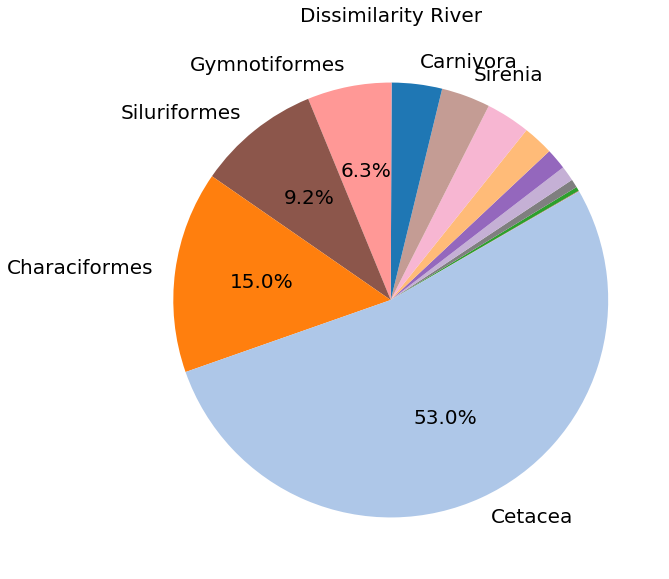

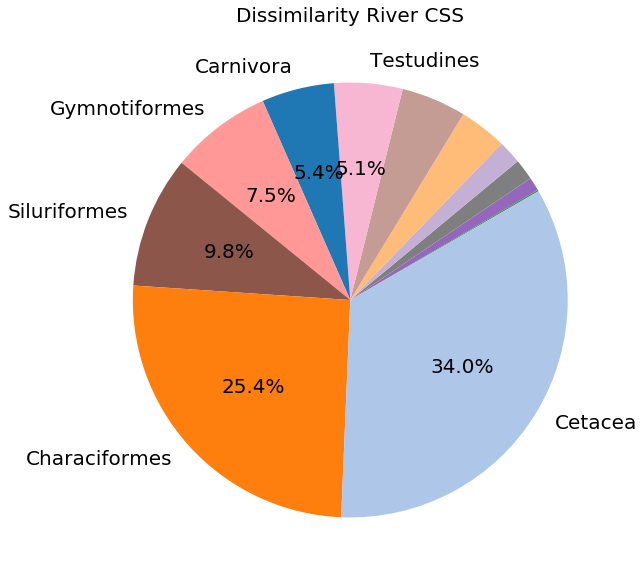

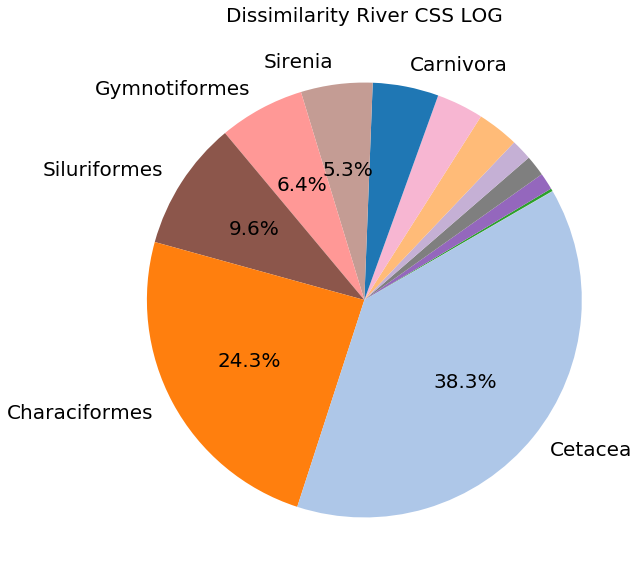

In [140]:
col_to_plot = ["Dissimilarity River","Dissimilarity River CSS",
               "Dissimilarity River CSS LOG"]
#scaledtaxamethod(dissim_rfr_df)
pieplots(scaledtaxamethod(dis_rfr_df_balanced_river,average=True,taxa=taxadf.loc[rivindex,:]),col_to_plot,"rfr_dis_river_mean_pie")

In [ ]:
sim_log_df

In [ ]:
col_to_plot=["Similarity OTU","Similarity OTU CSS","Similarity OTU MIN CSS"]
pieplots(scaled_taxa_by_level,None,"rfr_order_pie")

In [ ]:
scaled_taxa = taxadf.groupby("Order").count()
shape_of_df = scaled_taxa.shape
scaled_taxa_by_level_color = np.arange(0,shape_of_df[0])%10
col_to_plot =[scaled_taxa.columns[0]]
#ax_titles = ["Similarity OTU","Similarity OTU CSS", "Similarity OTU MIN CSS","Dissimilarity OTU","Dissimilarity OTU CSS", "Dissimilarity OTU MIN CSS"]
#fig,axes = plt.subplots(nrows = 3,ncols=2,figsize=(20,30))

cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0,1,10)]
plt.rcParams.update({'font.size': 15})

#axes.set_color_cycle(colors)
for i,j in enumerate(col_to_plot):
    #ax = axes[i%3,i//3]
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes()
    sortedindx = np.argsort(scaled_taxa[j])
    sortedcolor = [colors[k] for k in scaled_taxa_by_level_color[sortedindx]]
    sortedlabels =scaled_taxa.index[sortedindx].values
    sortedlabels[0:-6] =""
    ax.pie(x = scaled_taxa[j][sortedindx],labels=sortedlabels,colors=sortedcolor,startangle=30
          ,autopct=lambda p:  '{:.0f}'.format(p * 675 / 100) if p >= 2.90 else "")
    ax.set_title("Order distribution",fontsize = 20)
    fig.savefig(fname="orderdistrpie.png",transparent=True,dpi=300)

# Saving to CSV

In [140]:
rivcsv =open("rivertocsv.csv",mode="w")
writer =csv.writer(rivcsv,delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)


In [139]:
def write_df_to_csv(dataframe,classifier,Name,Notes=None):
    for j,i in enumerate(dataframe.index):
        confusion_flat = list(dataframe.Confusion[j].flatten())
        row =[classifier,i]+[""]*(2*int(np.sqrt(len(confusion_flat)))+1)+confusion_flat+[Name,Notes]
        writer.writerow(row)
#         print(row)

In [141]:
write_df_to_csv(loc_bnb_full,"BNB","loc_bnb_full")
write_df_to_csv(loc_bnb_riv,"BNB","loc_bnb_riv")
write_df_to_csv(loc_mnb_full,"MNB","loc_mnb_full")
write_df_to_csv(loc_mnb_riv,"MNB","loc_mnb_riv")


write_df_to_csv(loc_logl2_riv_sc, "LOGL2 stscale","loc_logl2_riv_sc","Standard scaler mean false, saga 1000")
write_df_to_csv(loc_logl2_riv_sc_mult, "LOGL2 stscale multinomial","loc_logl2_riv_sc_mult","scaler mean false,saga 1000, multinomial decision function")
write_df_to_csv(loc_logl2_riv_sc_ros_mult, "LOGL2 stscale multinomial ROS","loc_logl2_riv_sc_ros_mult","scaler mean false,saga 1000, multinomial decision function, randomoversample")


write_df_to_csv(loc_logl1_riv_sc, "LOGL1 stscale","loc_logl1_riv_sc","Standard scaler mean False, saga 1000")
write_df_to_csv(loc_logl1_riv_sc_mult, "LOGL1 stscale multinomial","loc_logl1_riv_sc_mult","Standard scaler mean False, saga 1000, multinomial decision function")
write_df_to_csv(loc_logl1_riv_sc_ros_mult, "LOGL1 stscale multinomial ROS","loc_logl1_riv_sc_ros_mult","Standard scaler mean False, saga 1000, multinomial decision function,randomoversample")

write_df_to_csv(loc_rfr_full, "RFR","loc_rfr_full")
write_df_to_csv(loc_rfr_riv, "RFR ","loc_rfr_riv")
write_df_to_csv(loc_rfr_riv_ros, "RFR ROS","loc_rfr_riv_ros","RandomOverSampling")
write_df_to_csv(loc_rfr_riv_smote, "RFR SMOTE","loc_rfr_riv_smote","SMOTE")
write_df_to_csv(loc_rfr_riv_smote1, "RFR SMOTE1","loc_rfr_riv_smote1","SMOTE1")
write_df_to_csv(loc_rfr_rivcsslog_smote2, "RFR SMOTE2","loc_rfr_rivcsslog_smote2","SMOTE2 and bootstrap allowed to vary")
write_df_to_csv(loc_rfr_rivcsslog_smote1, "RFR SMOTE1","loc_rfr_rivcsslog_smote1","SMOTE1 and bootstrap allowed to vary")

write_df_to_csv(loc_knn_riv, "KNN","loc_knn_riv")
write_df_to_csv(loc_knn_riv_adasyn, "KNN ADASYN","loc_knn_riv_adasyn","ADASYN")
write_df_to_csv(loc_knn_riv_ros, "KNN ROS","loc_knn_riv","RandomOverSampling")
write_df_to_csv(loc_knn_riv_smote, "KNN SMOTE","loc_knn_riv_smote","SMOTE")
write_df_to_csv(loc_knn_riv_smote2, "KNN SMOTE2","loc_knn_riv_smote2","SMOTE2")
write_df_to_csv(loc_knn_riv_smote1, "KNN SMOTE1","loc_knn_riv_smote1","SMOTE1")

In [142]:
loc_bnb_full.to_pickle("loc_bnb_full")
loc_bnb_riv.to_pickle("loc_bnb_riv")
loc_mnb_full.to_pickle("loc_mnb_full")
loc_mnb_riv.to_pickle("loc_mnb_riv")
loc_logl2_riv_sc.to_pickle("loc_logl2_riv_sc")
loc_logl2_riv_sc_mult.to_pickle("loc_logl2_riv_sc_mult")
loc_logl2_riv_sc_ros_mult.to_pickle("loc_logl2_riv_sc_ros_mult")
loc_logl1_riv_sc.to_pickle("loc_logl1_riv_sc")
loc_logl1_riv_sc_mult.to_pickle("loc_logl1_riv_sc_mult")
loc_logl1_riv_sc_ros_mult.to_pickle("loc_logl1_riv_sc_ros_mult")
loc_rfr_full.to_pickle("loc_rfr_full")
loc_rfr_riv.to_pickle("loc_rfr_riv")
loc_rfr_riv_ros.to_pickle("loc_rfr_riv_ros")
loc_rfr_riv_smote.to_pickle("loc_rfr_riv_smote")
loc_rfr_riv_smote1.to_pickle("loc_rfr_riv_smote1")
loc_rfr_rivcsslog_smote2.to_pickle("loc_rfr_rivcsslog_smote2")
loc_rfr_rivcsslog_smote1.to_pickle("loc_rfr_rivcsslog_smote1")
loc_knn_riv.to_pickle("loc_knn_riv")
loc_knn_riv_adasyn.to_pickle("loc_knn_riv_adasyn")
loc_knn_riv_ros.to_pickle("loc_knn_riv_ros")
loc_knn_riv_smote.to_pickle("loc_knn_riv_smote")
loc_knn_riv_smote2.to_pickle("loc_knn_riv_smote2")
loc_knn_riv_smote1.to_pickle("loc_knn_riv_smote1")

In [143]:
rivcsv.close()